In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import ast
from statistics import mean, stdev, median 

In [2]:
import re
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/lhch9550/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

##강의 데이터 전처리

In [4]:
df_course = pd.read_csv('ssg_courses_info.csv')

/home/lhch9550/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (0,7,10,15,17,18,19,23,26,34,35,38,39,40,41,44,45,51,52,54,55,62,66) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
# Define a function to extract description
def extract_description(dictionary_str):
    try:
        dictionary_list = ast.literal_eval(dictionary_str)
        if isinstance(dictionary_list, list) and len(dictionary_list) > 0:
            description = dictionary_list[0].get('description', '')
            return description
    except (SyntaxError, ValueError, TypeError):
        pass
    return ''

# Apply the function using apply()
df_course['label'] = df_course['areaOfTrainings'].apply(extract_description)

In [6]:
df_course['text'] = df_course['objective'] + df_course['content']
df_course = df_course[["title", "objective","label", 'text']]

In [7]:
# Drop rows with missing values in the 'title', 'objective', and 'label' columns
df_course = df_course.dropna(subset=['title', 'objective', 'label','text'])
df_course = df_course.drop_duplicates(subset=['title'],keep='last').reset_index()
df_course.shape

(23549, 5)

In [8]:
def has_non_english_chars(text):
    # Use regex to check for non-English characters
    return bool(re.search(r'[^\x00-\x7F]+', text))

mask = df_course['text'].apply(has_non_english_chars)
filtered_course_df = df_course[~mask]
filtered_course_df.shape

(13996, 5)

In [9]:
# Define a function to remove special characters and newline characters
chinese_pattern = r'[\u4e00-\u9fff]+'

import re
def remove_special_and_newline(text):
    # Remove special characters
    text= re.sub('[^a-zA-Z]+', ' ', text)
    text = re.sub(r'\r\n', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r'  +', ' ', text)
    return text

# Apply the function to the 'text' column
filtered_course_df['text'] = filtered_course_df['text'].apply(remove_special_and_newline)
filtered_course_df = filtered_course_df.dropna(subset=['objective','text'])
filtered_course_df.shape

<ipython-input-9-426a869b2070>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_course_df['text'] = filtered_course_df['text'].apply(remove_special_and_newline)


(13996, 5)

In [10]:
#filtered_course_df = filtered_course_df.reset_index()
filtered_course_df = filtered_course_df[~filtered_course_df['objective'].str.contains('https://')]
filtered_course_df = filtered_course_df[~filtered_course_df['objective'].str.contains('http://')]
filtered_course_df = filtered_course_df.reset_index()

In [11]:
# Initialize a list to store embeddings
sentence_tokenize_course = []

# Loop through the data and process each 'title' and 'objective'
for _, row in filtered_course_df.iterrows():
    title = row['title']
    objective = row['text']

    # Convert non-string "objective" values to strings
    if not isinstance(objective, str):
        objective = str(objective)

    # Split the objective into sentences
    sentences = nltk.sent_tokenize(objective, language='english')  # You can also use your own sentence splitting logic
    sentence_tokenize_course.append(sentences)

In [12]:
# Add the 'sentence_tokenize_skill' list as a new column in the DataFrame
filtered_course_df['tokenized_sentences'] = sentence_tokenize_course
filtered_course_df['tokenized_sentences'][2000]

['The course provides trainees with the skills and knowledge in using various therapist prescribed assessment tools and carry out therapist prescribed treatment plans to clients affected by physical injury illness developmental disabilities or psychosocial dysfunctions Trainees will also learn strategies to promote health and wellness related to active ageing Anatomy Physiology and Neurophysiology Biomechanics and Kinesiology Basic Assessment and Screening Rehabilitation Studies Person Centred Care Community Reintegration Group Dynamics and Facilitation Rehabilitation Studies Rehabilitation Studies Ethics and Legal Issues in Healthcare Company Project']

In [13]:
filtered_course_df.drop('level_0', axis=1, inplace=True)
filtered_course_df

,index,title,objective,label,text,tokenized_sentences
0,0,Microsoft Excel 2013 Pivot Table Proficiency,Pivot table is an efficient Excel tool for han...,Information and Communications,Pivot table is an efficient Excel tool for han...,[Pivot table is an efficient Excel tool for ha...
1,1,Air-Conditioning - Basic Maintenance for Home ...,"At the end of the module, participants would b...","Electricity , Gas and Air-conditioning",At the end of the module participants would be...,[At the end of the module participants would b...
2,2,Certificate in Athlete Life Coaching,The objective of this programme is to provide ...,Sports,The objective of this programme is to provide ...,[The objective of this programme is to provide...
3,3,Certificate Course in 2nd Grade Computer Aided...,This course provides participants with an intr...,Engineering,This course provides participants with an intr...,[This course provides participants with an int...
4,4,Certificate Course in 2nd Grade Mechanics II (...,This course provides participants with the kno...,Engineering,This course provides participants with the kno...,[This course provides participants with the kn...
...,...,...,...,...,...,...
13690,29906,"""Think Out Of The Box"" (Synchronous e-Learning)",Course to equip participants with the skills a...,Productivity and Innovation,Course to equip participants with the skills a...,[Course to equip participants with the skills ...
13691,29907,EC-Council Certified Ethical Hacker (Synchrono...,CEH is divided into 20 modules and delivered t...,Information and Communications,CEH is divided into modules and delivered thro...,[CEH is divided into modules and delivered thr...
13692,29911,Family Mediation Certification Programme (Modu...,"By the end of this course, learners will be ab...",Legal,By the end of this course learners will be abl...,[By the end of this course learners will be ab...
13693,29912,Family Mediation Certification Programme (Modu...,"By the end of this course, learners will be ab...",Legal,By the end of this course learners will be abl...,[By the end of this course learners will be ab...


In [14]:
##스킬 데이터 전처리

In [14]:
df_skill_proficiency = pd.read_csv('TSC_CCS_K&A.csv')
df_skill_application = pd.read_csv('TSC_Application.csv')
df_skill_description = pd.read_csv('TSC_CCS_Key.csv')

/home/lhch9550/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [15]:
df_skill_tmp = pd.merge(df_skill_proficiency, df_skill_description, on=['Sector','TSC_CCS Category','TSC_CCS Title','TSC_CCS Description','TSC_CCS_Type'], how='left')
df_skill_tmp = df_skill_tmp[['TSC_CCS Title','TSC_CCS Description','Proficiency Level','Proficiency Description','TSC_CCS Category','TSC_CCS Code']]
df_skill_tmp

,TSC_CCS Title,TSC_CCS Description,Proficiency Level,Proficiency Description,TSC_CCS Category,TSC_CCS Code
0,Audit Frameworks,Develop quality assurance frameworks to meet r...,4,Analyse the format and content of audit report,Assurance,ACC-AUD-4003-1.1
1,Audit Frameworks,Develop quality assurance frameworks to meet r...,4,Analyse the format and content of audit report,Assurance,ACC-AUD-4003-1.1
2,Audit Frameworks,Develop quality assurance frameworks to meet r...,4,Analyse the format and content of audit report,Assurance,ACC-AUD-4003-1.1
3,Audit Frameworks,Develop quality assurance frameworks to meet r...,4,Analyse the format and content of audit report,Assurance,ACC-AUD-4003-1.1
4,Audit Frameworks,Develop quality assurance frameworks to meet r...,4,Analyse the format and content of audit report,Assurance,ACC-AUD-4003-1.1
...,...,...,...,...,...,...
138779,Workplace Safety and Health System Management,Develop Workplace Safety and Health (WSH) fram...,6,Evaluate organisation’s Workplace Safety and H...,Workplace Safety and Health Management,WPH-WSH-6086-1.1
138780,Workplace Safety and Health System Management,Develop Workplace Safety and Health (WSH) fram...,6,Evaluate organisation’s Workplace Safety and H...,Workplace Safety and Health Management,WPH-WSH-6086-1.1
138781,Workplace Safety and Health System Management,Develop Workplace Safety and Health (WSH) fram...,6,Evaluate organisation’s Workplace Safety and H...,Workplace Safety and Health Management,WPH-WSH-6086-1.1
138782,Workplace Safety and Health System Management,Develop Workplace Safety and Health (WSH) fram...,6,Evaluate organisation’s Workplace Safety and H...,Workplace Safety and Health Management,WPH-WSH-6086-1.1


In [16]:
df_skill = df_skill_tmp.drop_duplicates(['TSC_CCS Title','TSC_CCS Description','Proficiency Level','Proficiency Description','TSC_CCS Code'])
df_skill

,TSC_CCS Title,TSC_CCS Description,Proficiency Level,Proficiency Description,TSC_CCS Category,TSC_CCS Code
0,Audit Frameworks,Develop quality assurance frameworks to meet r...,4,Analyse the format and content of audit report,Assurance,ACC-AUD-4003-1.1
5,Audit Frameworks,Develop quality assurance frameworks to meet r...,5,Assess impact on external audit frameworks ari...,Assurance,ACC-AUD-5003-1.1
12,Auditing and Assurance Standards,Use applicable auditing and assurance standard...,4,Perform engagement procedures in accordance wi...,Assurance,ACC-AUD-4001-1.1
17,Auditing and Assurance Standards,Use applicable auditing and assurance standard...,5,Guide the engagement team to perform engagemen...,Assurance,ACC-AUD-5001-1.1
22,Auditing and Assurance Standards,Use applicable auditing and assurance standard...,6,Determine whether engagement is performed in a...,Assurance,ACC-AUD-6001-1.1
...,...,...,...,...,...,...
138700,Workplace Safety and Health System Management,Develop Workplace Safety and Health (WSH) fram...,2,Apply Workplace Safety and Health (WSH) proced...,Workplace Safety and Health Management,WPH-WSH-2086-1.1
138711,Workplace Safety and Health System Management,Develop Workplace Safety and Health (WSH) fram...,3,Coordinate organisation’s Workplace Safety and...,Workplace Safety and Health Management,WPH-WSH-3086-1.1
138726,Workplace Safety and Health System Management,Develop Workplace Safety and Health (WSH) fram...,4,Facilitate development and implementation of W...,Workplace Safety and Health Management,WPH-WSH-4086-1.1
138754,Workplace Safety and Health System Management,Develop Workplace Safety and Health (WSH) fram...,5,Design a Workplace Safety and Health (WSH) Man...,Workplace Safety and Health Management,WPH-WSH-5086-1.1


In [17]:
df_skill.dropna(subset=['TSC_CCS Description', 'Proficiency Description'], inplace=True)
df_skill['text'] = df_skill.groupby(['TSC_CCS Description'])['Proficiency Description'].transform(lambda x: '. '.join(x))
df_skill = df_skill.drop_duplicates(['TSC_CCS Description']).reset_index().drop(['index'], axis='columns')
df_skill = df_skill.drop_duplicates(['TSC_CCS Code']).reset_index().drop(['index'], axis='columns')
df_skill

<ipython-input-17-984317b99cec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_skill.dropna(subset=['TSC_CCS Description', 'Proficiency Description'], inplace=True)
<ipython-input-17-984317b99cec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_skill['text'] = df_skill.groupby(['TSC_CCS Description'])['Proficiency Description'].transform(lambda x: '. '.join(x))


,TSC_CCS Title,TSC_CCS Description,Proficiency Level,Proficiency Description,TSC_CCS Category,TSC_CCS Code,text
0,Audit Frameworks,Develop quality assurance frameworks to meet r...,4,Analyse the format and content of audit report,Assurance,ACC-AUD-4003-1.1,Analyse the format and content of audit report...
1,Auditing and Assurance Standards,Use applicable auditing and assurance standard...,4,Perform engagement procedures in accordance wi...,Assurance,ACC-AUD-4001-1.1,Perform engagement procedures in accordance wi...
2,Auditor Independence,Possess the state of mind and appearance where...,3,Communicate importance of auditor's independen...,Assurance,ACC-PVE-3001-1.1,Communicate importance of auditor's independen...
3,Engagement Completion and Reporting,Perform procedures involved prior to expressin...,4,Perform engagement completion procedures,Assurance,ACC-AUD-4004-1.1,Perform engagement completion procedures. Eval...
4,Engagement Execution,Perform assurance procedures in accordance wit...,4,Perform assurance procedures,Assurance,ACC-AUD-4005-1.1,Perform assurance procedures. Perform assuranc...
...,...,...,...,...,...,...,...
2575,Workplace Safety and Health Management in Manu...,Manage the operational issues associated with ...,2,Identify common safety and health hazards and ...,Workplace Safety and Health Management,WPH-WSH-2081-1.1,Identify common safety and health hazards and ...
2576,Workplace Safety and Health Management in Mari...,Manage the operational issues associated with ...,2,Identify common safety and health hazards and ...,Workplace Safety and Health Management,WPH-WSH-2082-1.1,Identify common safety and health hazards and ...
2577,Workplace Safety and Health Management in Serv...,Manage the operational issues associated with ...,2,Identify common safety and health hazards and ...,Workplace Safety and Health Management,WPH-WSH-2083-1.1,Identify common safety and health hazards and ...
2578,Workplace Safety and Health Policy Development,Develop organisational workplace safety and he...,1,Monitor legal compliance and report incidents ...,Workplace Safety and Health Management,WPH-WSH-1084-1.1,Monitor legal compliance and report incidents ...


In [18]:
df_skill['combined_text'] = df_skill['TSC_CCS Description'] + '. ' + df_skill['text']
df_skill

,TSC_CCS Title,TSC_CCS Description,Proficiency Level,Proficiency Description,TSC_CCS Category,TSC_CCS Code,text,combined_text
0,Audit Frameworks,Develop quality assurance frameworks to meet r...,4,Analyse the format and content of audit report,Assurance,ACC-AUD-4003-1.1,Analyse the format and content of audit report...,Develop quality assurance frameworks to meet r...
1,Auditing and Assurance Standards,Use applicable auditing and assurance standard...,4,Perform engagement procedures in accordance wi...,Assurance,ACC-AUD-4001-1.1,Perform engagement procedures in accordance wi...,Use applicable auditing and assurance standard...
2,Auditor Independence,Possess the state of mind and appearance where...,3,Communicate importance of auditor's independen...,Assurance,ACC-PVE-3001-1.1,Communicate importance of auditor's independen...,Possess the state of mind and appearance where...
3,Engagement Completion and Reporting,Perform procedures involved prior to expressin...,4,Perform engagement completion procedures,Assurance,ACC-AUD-4004-1.1,Perform engagement completion procedures. Eval...,Perform procedures involved prior to expressin...
4,Engagement Execution,Perform assurance procedures in accordance wit...,4,Perform assurance procedures,Assurance,ACC-AUD-4005-1.1,Perform assurance procedures. Perform assuranc...,Perform assurance procedures in accordance wit...
...,...,...,...,...,...,...,...,...
2575,Workplace Safety and Health Management in Manu...,Manage the operational issues associated with ...,2,Identify common safety and health hazards and ...,Workplace Safety and Health Management,WPH-WSH-2081-1.1,Identify common safety and health hazards and ...,Manage the operational issues associated with ...
2576,Workplace Safety and Health Management in Mari...,Manage the operational issues associated with ...,2,Identify common safety and health hazards and ...,Workplace Safety and Health Management,WPH-WSH-2082-1.1,Identify common safety and health hazards and ...,Manage the operational issues associated with ...
2577,Workplace Safety and Health Management in Serv...,Manage the operational issues associated with ...,2,Identify common safety and health hazards and ...,Workplace Safety and Health Management,WPH-WSH-2083-1.1,Identify common safety and health hazards and ...,Manage the operational issues associated with ...
2578,Workplace Safety and Health Policy Development,Develop organisational workplace safety and he...,1,Monitor legal compliance and report incidents ...,Workplace Safety and Health Management,WPH-WSH-1084-1.1,Monitor legal compliance and report incidents ...,Develop organisational workplace safety and he...


In [19]:
# Initialize a list to store embeddings
sentence_tokenize_skill = []

# Loop through the data and process each 'title' and 'objective'
for _, row in df_skill.iterrows():
    title = row['TSC_CCS Title']
    objective = row['combined_text']

    # Convert non-string "objective" values to strings
    if not isinstance(objective, str):
        objective = str(objective)

    # Split the objective into sentences
    sentences = nltk.sent_tokenize(objective)  # You can also use your own sentence splitting logic
    sentence_tokenize_skill.append(sentences)
    
# Add the 'sentence_tokenize_skill' list as a new column in the DataFrame
df_skill['tokenized_sentences'] = sentence_tokenize_skill
df_skill

,TSC_CCS Title,TSC_CCS Description,Proficiency Level,Proficiency Description,TSC_CCS Category,TSC_CCS Code,text,combined_text,tokenized_sentences
0,Audit Frameworks,Develop quality assurance frameworks to meet r...,4,Analyse the format and content of audit report,Assurance,ACC-AUD-4003-1.1,Analyse the format and content of audit report...,Develop quality assurance frameworks to meet r...,[Develop quality assurance frameworks to meet ...
1,Auditing and Assurance Standards,Use applicable auditing and assurance standard...,4,Perform engagement procedures in accordance wi...,Assurance,ACC-AUD-4001-1.1,Perform engagement procedures in accordance wi...,Use applicable auditing and assurance standard...,[Use applicable auditing and assurance standar...
2,Auditor Independence,Possess the state of mind and appearance where...,3,Communicate importance of auditor's independen...,Assurance,ACC-PVE-3001-1.1,Communicate importance of auditor's independen...,Possess the state of mind and appearance where...,[Possess the state of mind and appearance wher...
3,Engagement Completion and Reporting,Perform procedures involved prior to expressin...,4,Perform engagement completion procedures,Assurance,ACC-AUD-4004-1.1,Perform engagement completion procedures. Eval...,Perform procedures involved prior to expressin...,[Perform procedures involved prior to expressi...
4,Engagement Execution,Perform assurance procedures in accordance wit...,4,Perform assurance procedures,Assurance,ACC-AUD-4005-1.1,Perform assurance procedures. Perform assuranc...,Perform assurance procedures in accordance wit...,[Perform assurance procedures in accordance wi...
...,...,...,...,...,...,...,...,...,...
2575,Workplace Safety and Health Management in Manu...,Manage the operational issues associated with ...,2,Identify common safety and health hazards and ...,Workplace Safety and Health Management,WPH-WSH-2081-1.1,Identify common safety and health hazards and ...,Manage the operational issues associated with ...,[Manage the operational issues associated with...
2576,Workplace Safety and Health Management in Mari...,Manage the operational issues associated with ...,2,Identify common safety and health hazards and ...,Workplace Safety and Health Management,WPH-WSH-2082-1.1,Identify common safety and health hazards and ...,Manage the operational issues associated with ...,[Manage the operational issues associated with...
2577,Workplace Safety and Health Management in Serv...,Manage the operational issues associated with ...,2,Identify common safety and health hazards and ...,Workplace Safety and Health Management,WPH-WSH-2083-1.1,Identify common safety and health hazards and ...,Manage the operational issues associated with ...,[Manage the operational issues associated with...
2578,Workplace Safety and Health Policy Development,Develop organisational workplace safety and he...,1,Monitor legal compliance and report incidents ...,Workplace Safety and Health Management,WPH-WSH-1084-1.1,Monitor legal compliance and report incidents ...,Develop organisational workplace safety and he...,[Develop organisational workplace safety and h...


In [24]:
##직업데이터 전처리

In [21]:
# Try reading the CSV file with different encodings
encodings_to_try = ['utf-8', 'ISO-8859-1', 'utf-16']

for encoding in encodings_to_try:
    try:
        df_job = pd.read_csv('df_job_salary.csv', encoding=encoding)
        break  # If successful, exit the loop
    except UnicodeDecodeError:
        continue  # If not successful, try the next encoding

In [24]:
df_job = df_job[['job_code','title','description','track','key_tasks','min_salary','max_salary','sector']]
df_job

,job_code,title,description,track,key_tasks,min_salary,max_salary,sector
0,21491.BIO.01.002,Engineer,['The Engineer ensures the equipment and syste...,Engineering and Maintenance,['Analyse data to identify areas WHERE energ...,3640.0,5615.0,Biopharmaceuticals Manufacturing
1,11202.BIO.01.007,Engineering and Maintenance Director,['The Engineering and Maintenance Director ove...,Engineering and Maintenance,"['Approve business continuity policies, strate...",5000.0,13800.0,Biopharmaceuticals Manufacturing
2,13291.BIO.01.006,Engineering and Maintenance Manager,"[""The Engineering and Maintenance Manager supe...",Engineering and Maintenance,['Activate contingency plans when delays or la...,5611.0,9600.0,Biopharmaceuticals Manufacturing
3,81000.BIO.01.004,Engineering and Maintenance Supervisor,['The Engineering and Maintenance Supervisor o...,Engineering and Maintenance,['Assign responsibilities and resources to per...,NaN,NaN,Biopharmaceuticals Manufacturing
4,21491.BIO.01.004,Principal Engineer,['The Principal Engineer uses knowledge in adv...,Engineering and Maintenance,['Anticipate changes to energy resource and ut...,NaN,NaN,Biopharmaceuticals Manufacturing
...,...,...,...,...,...,...,...,...
1451,24131.FIN.02.001,Investment Research Analyst,['The Investment Research Analyst analyses ind...,-,['Analyse and evaluate investment opportunitie...,4292.0,7208.0,Finance
1452,24132.FIN.02.002,Risk Manager,['The Risk Manager oversees all types of risk ...,-,['Align risk management strategies and policie...,5980.0,13361.0,Finance
1453,24141.FIN.01.001,Securities Dealer,['The Securities Dealer or Stock Broker is par...,Stockbroking,['Acquire new clients and perform client accep...,2500.0,4000.0,Finance
1454,24341.FIN.01.001,Trader,['The Trader facilitates trade transactions an...,Stockbroking,['Develop client relationships to facilitate n...,2500.0,4000.0,Finance


In [25]:
# Convert the string literals to lists
df_job['description'] = df_job['description'].apply(ast.literal_eval)
df_job['key_tasks'] = df_job['key_tasks'].apply(ast.literal_eval)

# Combine the 'description' and 'key_tasks' lists into a new column 'combined_tasks'
df_job['tokenized_sentences'] = df_job.apply(lambda row: row['description'] + row['key_tasks'], axis=1)

# Display the updated DataFrame
df_job

,job_code,title,description,track,key_tasks,min_salary,max_salary,sector,tokenized_sentences
0,21491.BIO.01.002,Engineer,[The Engineer ensures the equipment and system...,Engineering and Maintenance,[Analyse data to identify areas WHERE energy...,3640.0,5615.0,Biopharmaceuticals Manufacturing,[The Engineer ensures the equipment and system...
1,11202.BIO.01.007,Engineering and Maintenance Director,[The Engineering and Maintenance Director over...,Engineering and Maintenance,"[Approve business continuity policies, strateg...",5000.0,13800.0,Biopharmaceuticals Manufacturing,[The Engineering and Maintenance Director over...
2,13291.BIO.01.006,Engineering and Maintenance Manager,[The Engineering and Maintenance Manager super...,Engineering and Maintenance,[Activate contingency plans when delays or lap...,5611.0,9600.0,Biopharmaceuticals Manufacturing,[The Engineering and Maintenance Manager super...
3,81000.BIO.01.004,Engineering and Maintenance Supervisor,[The Engineering and Maintenance Supervisor ov...,Engineering and Maintenance,[Assign responsibilities and resources to perf...,NaN,NaN,Biopharmaceuticals Manufacturing,[The Engineering and Maintenance Supervisor ov...
4,21491.BIO.01.004,Principal Engineer,[The Principal Engineer uses knowledge in adva...,Engineering and Maintenance,[Anticipate changes to energy resource and uti...,NaN,NaN,Biopharmaceuticals Manufacturing,[The Principal Engineer uses knowledge in adva...
...,...,...,...,...,...,...,...,...,...
1451,24131.FIN.02.001,Investment Research Analyst,[The Investment Research Analyst analyses indu...,-,[Analyse and evaluate investment opportunities...,4292.0,7208.0,Finance,[The Investment Research Analyst analyses indu...
1452,24132.FIN.02.002,Risk Manager,[The Risk Manager oversees all types of risk a...,-,[Align risk management strategies and policies...,5980.0,13361.0,Finance,[The Risk Manager oversees all types of risk a...
1453,24141.FIN.01.001,Securities Dealer,[The Securities Dealer or Stock Broker is part...,Stockbroking,[Acquire new clients and perform client accept...,2500.0,4000.0,Finance,[The Securities Dealer or Stock Broker is part...
1454,24341.FIN.01.001,Trader,[The Trader facilitates trade transactions and...,Stockbroking,[Develop client relationships to facilitate ne...,2500.0,4000.0,Finance,[The Trader facilitates trade transactions and...


In [26]:
df_job['tokenized_sentences'][0]

['The Engineer ensures the equipment and systems within a manufacturing facility are in good working order.',
 'The individual provides technical guidance and direction for the installation of equipment and systems, develops the maintenance plan, identifies issues and recommends solutions.',
 'The Engineer conducts feasibility assessments on new technologies and develops solutions to optimise machine availability and energy efficiency.',
 'Responsibilities include ensuring compliance with standard operating procedures, Health Safety and Environment (HSE) regulations and Current Good Manufacturing Practices (CGMPs).',
 'The Engineer develops guidelines and conducts equipment qualification and validation in line with biopharmaceuticals manufacturing regulatory requirements.<br><br>The innovative, analytical and inquisitive individual solves complex engineering problems as part of a team, and mentors colleagues by sharing technical advice and solutions with them.',
 'Analyse data to ident

In [29]:
##임베딩

In [27]:
df_job = df_job.rename(columns={'track':'job_label','job_code':'id','sector':'sector_label'})
df_job_filtered = df_job[['id','job_label','tokenized_sentences','sector_label']]
df_job_filtered['id'].value_counts()

51200.FSV.03.001    1
14121.FSV.01.006    1
51501.HAS.01.002    1
24141.FIN.02.001    1
13291.PTP.04.005    1
                   ..
52202.LSP.02.001    1
21213.INS.01.004    1
96211.HAS.01.004    1
24120.FIN.02.002    1
21711.SEA.01.002    1
Name: id, Length: 1456, dtype: int64

In [28]:
df_skill = df_skill.rename(columns={'TSC_CCS Category':'skill_label', 'TSC_CCS Code':'id'})
df_skill_filtered = df_skill[['id','skill_label','tokenized_sentences']]
df_skill_filtered['id'].value_counts()

FSE-RND-4003-1.1-1    1
PRE-EPM-1068-1.1      1
MAR-MMF-1002-1.1      1
BEV-DES-2050-1.1      1
PRE-MPR-1035-1.1      1
                     ..
ICT-DIT-4026-1.1      1
FSE-PMN-3016-1.1-1    1
FSS-CEX-1038-1.1      1
PTP-BOP-2008-1.1      1
WPH-QUA-5021-1.1      1
Name: id, Length: 2580, dtype: int64

In [29]:
df_course = filtered_course_df.rename(columns={'title':'id','label':'course_label'})
df_course_filtered = df_course[['id','course_label','text']]
df_course_filtered = df_course_filtered .rename(columns={'text':'tokenized_sentences'})
df_course_filtered['id'].value_counts()

MLC - Embracing Technology in Security Industry                                                                    1
Modular course: Learning and People Development                                                                    1
Early Childhood Aquatic Skills                                                                                     1
Basic Cardiac Life Support + AED                                                                                   1
SIJ-RSVP-Basic Computer (Win 10)                                                                                   1
                                                                                                                  ..
NSA - Train Your Brain to Concentrate and Focus                                                                    1
Post-Diploma Certificate in Principles of Endoscopy Nursing (part of Specialist Diploma in Nursing (Endoscopy))    1
Dining Etiquette & Professional Image for Professionals and Exec

In [29]:
concatenated_df = pd.concat([df_job_filtered, df_skill_filtered, df_course_filtered], ignore_index=True)
concatenated_df

,id,job_label,tokenized_sentences,sector_label,skill_label,course_label
0,21491.BIO.01.002,Engineering and Maintenance,[The Engineer ensures the equipment and system...,Biopharmaceuticals Manufacturing,NaN,NaN
1,11202.BIO.01.007,Engineering and Maintenance,[The Engineering and Maintenance Director over...,Biopharmaceuticals Manufacturing,NaN,NaN
2,13291.BIO.01.006,Engineering and Maintenance,[The Engineering and Maintenance Manager super...,Biopharmaceuticals Manufacturing,NaN,NaN
3,81000.BIO.01.004,Engineering and Maintenance,[The Engineering and Maintenance Supervisor ov...,Biopharmaceuticals Manufacturing,NaN,NaN
4,21491.BIO.01.004,Engineering and Maintenance,[The Principal Engineer uses knowledge in adva...,Biopharmaceuticals Manufacturing,NaN,NaN
...,...,...,...,...,...,...
17726,"""Think Out Of The Box"" (Synchronous e-Learning)",NaN,Course to equip participants with the skills a...,NaN,NaN,Productivity and Innovation
17727,EC-Council Certified Ethical Hacker (Synchrono...,NaN,CEH is divided into modules and delivered thro...,NaN,NaN,Information and Communications
17728,Family Mediation Certification Programme (Modu...,NaN,By the end of this course learners will be abl...,NaN,NaN,Legal
17729,Family Mediation Certification Programme (Modu...,NaN,By the end of this course learners will be abl...,NaN,NaN,Legal


In [32]:
from transformers import AutoTokenizer, AutoModel
import torch

# Check if GPU is available and set the device accordingly
if torch.cuda.is_available():
    cuda = torch.device('cuda')
else:
    cuda = torch.device('cpu')

# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state  # Last hidden state contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

# Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

In [ ]:
# Move the model to the GPU if available
model = model.to(cuda)

# Initialize a list to store embeddings
sentence_embeddings_list = []

# Loop through the data and process each 'title' and 'objective'
for _, row in concatenated_df.iterrows():
    title = row['id']
    objective = row['tokenized_sentences'] #(나중에 text로 고치기)

    # Tokenize sentences
    encoded_input = tokenizer(objective, padding=True, truncation=True, max_length=200, return_tensors='pt')

    # Move the input tensors to the GPU if available
    encoded_input = {key: value.to(cuda) for key, value in encoded_input.items()}

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Perform pooling (mean pooling in this case)
    sentence_embedding = mean_pooling(model_output, encoded_input['attention_mask'])

    # Append the sentence embedding to the list
    sentence_embeddings_list.append(sentence_embedding)

In [ ]:
# Initialize an empty list to store the average embeddings
average_embeddings_list = []

# Iterate through the list of embeddings
for sentence_embedding in sentence_embeddings_list:
    # Calculate the mean along dimension 0 to get the average for each sentence
    average_embedding = torch.mean(sentence_embedding, dim=0)
    # Append the average embedding to the list
    average_embeddings_list.append(average_embedding)

average_embeddings_list[0].shape

# Convert each element to a NumPy array
numpy_array_list = [tensor.cpu().numpy() for tensor in average_embeddings_list]

In [ ]:
import umap.umap_ as umap

# Create a UMAP reducer
umap_reducer = umap.UMAP(n_neighbors=100, min_dist=0.1, metric='euclidean', unique=True)
# Fit and transform the vectors

umap_embeddings = umap_reducer.fit_transform(numpy_array_list)

In [ ]:
# Extract all labels from the 'concatenated_df' DataFrame
labels = concatenated_df['course_label'].tolist()

# Create a DataFrame for the UMAP embeddings
umap_df = pd.DataFrame({'UMAP Dimension 1': umap_embeddings[:, 0],
                        'UMAP Dimension 2': umap_embeddings[:, 1],
                        'Labels': labels})

# Define the labels you want to include in the visualization
selected_labels = ['Information and Communications', 'Business Management', 'Engineering', 'Healthcare', 'Food and Beverages','Education and Training','Personal Development','Accounting, Banking & Finance','Workplace Safety and Health']

# Define a color map to assign unique colors to selected labels
color_map = {
    'Information and Communications': 'blue',
    'Business Management': 'green',
    'Engineering': 'red',
    'Healthcare':'yellow',
    'Food and Beverages':'black',
    'Education and Training':'cyan',
    'Personal Development':'lawngreen',
    'Accounting, Banking & Finance':'deeppink',
    'Workplace Safety and Health':'violet'

}

# Create a scatter plot for the selected labels with colors
plt.figure(figsize=(20, 16))
for label, color in color_map.items():
    subset_df = umap_df[umap_df['Labels'] == label]
    sns.scatterplot(data=subset_df, x='UMAP Dimension 1', y='UMAP Dimension 2', label=label, color=color, s=20)

# Create a scatter plot for the other labels without colors
other_labels_df = umap_df[~umap_df['Labels'].isin(selected_labels)]
sns.scatterplot(data=other_labels_df, x='UMAP Dimension 1', y='UMAP Dimension 2', hue=None, s=5, alpha=0.3)

plt.title('UMAP Visualization (Course Coloured)')
plt.legend()
plt.show()

In [ ]:
#코사인 유사도 계산

In [ ]:
concatenated_df['embeddings'] = numpy_array_list
job_embedded_df = concatenated_df[~concatenated_df['job_label'].isna()]
skill_embedded_df = concatenated_df[~concatenated_df['skill_label'].isna()]
course_embedded_df = concatenated_df[~concatenated_df['course_label'].isna()]

In [ ]:
vectorized_skill = skill_embedded_df['embeddings'].tolist()
vectorized_skill = np.array(vectorized_skill).astype(np.float64)

vectorized_job = job_embedded_df['embeddings'].tolist()
vectorized_job = np.array(vectorized_job).astype(np.float64)

vectorized_course = course_embedded_df['embeddings'].tolist()
vectorized_course = np.array(vectorized_course).astype(np.float64)
vectorized_course.shape

In [ ]:
course_skill_cosine_matrix = cosine_similarity(vectorized_course, vectorized_skill)
course_skill_matrix_df = pd.DataFrame(course_skill_cosine_matrix, index=course_embedded_df.id, columns=skill_embedded_df.id)

In [ ]:
course_skill_matrix_df

In [ ]:
course_job_cosine_matrix = cosine_similarity(vectorized_course, vectorized_job)
course_job_matrix_df = pd.DataFrame(course_job_cosine_matrix, index=course_embedded_df.id, columns=job_embedded_df.id)

In [ ]:
course_job_matrix_df

In [ ]:
combined_df = pd.concat([course_job_matrix_df, course_skill_matrix_df], axis=1)
combined_df

In [ ]:
combined_df.to_csv('combined_df.csv')

In [30]:
combined_df = pd.read_csv('combined_df.csv')
combined_df.set_index('id', inplace=True)
combined_df

,21491.BIO.01.002,11202.BIO.01.007,13291.BIO.01.006,81000.BIO.01.004,21491.BIO.01.004,31171.BIO.01.002,31171.BIO.01.001,11202.BIO.01.004,21411.BIO.01.001,13211.BIO.02.003,...,WPH-QUA-5021-1.1,WPH-TEM-3017-1.1,WPH-TEM-3011-1.1,WPH-WSH-2079-1.1,WPH-WSH-2080-1.1,WPH-WSH-2081-1.1,WPH-WSH-2082-1.1,WPH-WSH-2083-1.1,WPH-WSH-1084-1.1,WPH-WSH-2085-1.1
id,,,,,,,,,,,,,,,,,,,,,
Microsoft Excel 2013 Pivot Table Proficiency,0.194556,0.226599,0.236577,0.168272,0.192360,0.144812,0.130970,0.158558,0.165296,0.213930,...,0.122777,0.069214,0.190008,0.116900,0.076010,0.105481,0.106867,0.118039,0.027858,0.070382
Air-Conditioning - Basic Maintenance for Home Split Unit,0.463462,0.332766,0.303968,0.389904,0.424683,0.437648,0.438182,0.284278,0.360169,0.291673,...,0.259642,0.091802,0.191264,0.385306,0.337609,0.391550,0.311932,0.382708,0.285145,0.258679
Certificate in Athlete Life Coaching,0.106445,0.174246,0.275214,0.099131,0.116125,0.044984,0.086047,0.161490,0.134872,0.188044,...,0.059935,0.002637,0.077771,0.131388,0.061322,0.087407,0.075480,0.124139,0.197492,0.059241
Certificate Course in 2nd Grade Computer Aided Drafting (For Steam Engineers),0.276073,0.224004,0.216180,0.233198,0.287711,0.272979,0.232479,0.247889,0.331035,0.267415,...,0.070283,0.038585,0.183365,0.102640,0.134648,0.139846,0.085284,0.074175,0.085680,0.141346
Certificate Course in 2nd Grade Mechanics II (For Steam Engineers),0.353463,0.230359,0.182889,0.209073,0.311216,0.296133,0.336991,0.126780,0.269016,0.162624,...,0.086786,0.075635,0.160272,0.114358,0.129221,0.213246,0.128900,0.152158,0.085555,0.167762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"""Think Out Of The Box"" (Synchronous e-Learning)",0.210901,0.333999,0.341544,0.235051,0.242131,0.212703,0.209905,0.356412,0.342725,0.380354,...,0.225401,0.170847,0.284060,0.267983,0.255718,0.290535,0.238836,0.306993,0.271321,0.217270
EC-Council Certified Ethical Hacker (Synchronous e-learning),0.250889,0.224836,0.248210,0.209263,0.248646,0.223167,0.189617,0.192802,0.185328,0.217207,...,0.214030,0.266393,0.194591,0.195491,0.154658,0.164491,0.191215,0.189100,0.282373,0.232613
Family Mediation Certification Programme (Module 1) Family Law,0.142952,0.163439,0.215198,0.166790,0.143191,0.112655,0.142827,0.186035,0.174769,0.173875,...,0.080103,0.020701,0.013030,0.179699,0.179039,0.161446,0.137110,0.167422,0.209882,0.140137


In [32]:
course_jobskill_matrix = combined_df.values
course_jobskill_matrix.shape

(13695, 4036)

In [33]:
threshold = 0.6

filtered_matrix = np.where(course_jobskill_matrix < threshold, 0, course_jobskill_matrix)

# Replace non-zero values with 1
filtered_matrix[filtered_matrix != 0] = 1

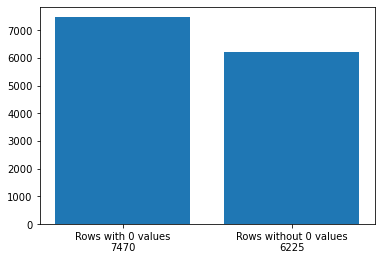

In [34]:
# Count rows with at least one "1"
row_counts = np.sum(filtered_matrix, axis=1) > 0
rows_with_ones = np.sum(row_counts)

# Calculate the number of rows with 0 and 1
rows_with_zeros = filtered_matrix.shape[0] - rows_with_ones

# Create a bar chart to visualize the comparison
labels = ['Rows with 0 values\n{}'.format(rows_with_zeros), 'Rows without 0 values\n{}'.format(rows_with_ones)]
values = [rows_with_zeros, rows_with_ones]

plt.bar(labels, values)
plt.show()

In [35]:
# Transpose the matrix
transposed_matrix = np.transpose(filtered_matrix)

# Perform matrix multiplication to project onto Set A
monopartite_matrix = np.dot(filtered_matrix, transposed_matrix)
monopartite_matrix[np.diag_indices_from(monopartite_matrix)] = 0
monopartite_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

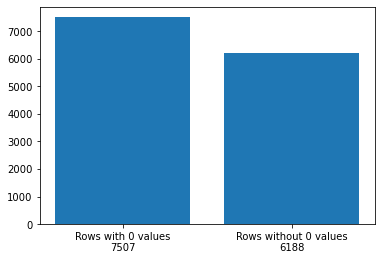

In [36]:
# Count rows with at least one "1"
row_counts = np.sum(monopartite_matrix, axis=1) > 0
rows_with_ones = np.sum(row_counts)

# Calculate the number of rows with 0 and 1
rows_with_zeros = monopartite_matrix.shape[0] - rows_with_ones

# Create a bar chart to visualize the comparison
labels = ['Rows with 0 values\n{}'.format(rows_with_zeros), 'Rows without 0 values\n{}'.format(rows_with_ones)]
values = [rows_with_zeros, rows_with_ones]

plt.bar(labels, values)
plt.show()

In [37]:
G = nx.Graph()
n = monopartite_matrix.shape[0]

for i in range(n):
    for j in range(i + 1, n):
        weight = float(monopartite_matrix[i][j])  # This should be the weight of the edge
        if weight > 0:
          G.add_edge(i, j, weight=weight)

In [38]:
# Extract node names from your original DataFrame (assuming they are in the rows)
node_names = combined_df.index

# Create a mapping of node indices to node names based on your filtered_matrix
node_indices = np.arange(filtered_matrix.shape[0])

# Create a dictionary to map node indices to their names
node_index_to_name = {index: name for index, name in zip(node_indices, node_names)}

# Add node names as attributes to the graph nodes
for node in G.nodes:
    G.nodes[node]['name'] = node_index_to_name[node]

In [39]:
filtered_course_df_columns = ['id', 'label']

# Iterate over nodes in the graph and add labels
for node in G.nodes():
    # Get the name attribute from the graph
    node_name = G.nodes[node]['name']

    # Find the corresponding row in filtered_course_df based on the 'title' column
    corresponding_row = filtered_course_df[filtered_course_df['title'] == node_name]

    # If a matching row is found, extract the label and assign it to the node
    if not corresponding_row.empty:
        label_value = corresponding_row.iloc[0][filtered_course_df_columns[1]]
        G.nodes[node]['label'] = label_value
    else:
        # Handle the case where no matching row is found, you can choose to skip or assign a default label
        G.nodes[node]['label'] = 'Unknown'

In [40]:
row_sums = np.sum(filtered_matrix, axis=1)
course_index = combined_df.index
course_coverage_df = pd.DataFrame(data={'row_sum': row_sums}, index=course_index)

# Iterate through the nodes in the graph and update the 'row_sum' attribute
for node in G.nodes():
    node_name = G.nodes[node]['name']
    
    # Check if the node_name is present in the DataFrame index
    if node_name in course_coverage_df.index:
        # Update the 'row_sum' attribute with the corresponding value from the DataFrame
        G.nodes[node]['course_coverage'] = course_coverage_df.loc[node_name, 'row_sum']

In [44]:
# Create your graph G with label attributes

# Step 1: Create subgraphs based on labels
subgraphs = {}
for node, data in G.nodes(data=True):
    label = data['label']
    if label not in subgraphs:
        subgraphs[label] = nx.Graph()
    subgraphs[label].add_node(node)

for edge in G.edges():
    u, v = edge
    label_u = G.nodes[u]['label']
    label_v = G.nodes[v]['label']
    if label_u == label_v:
        subgraphs[label_u].add_edge(u, v)

# Step 2: Calculate clustering coefficient for each subgraph
clustering_coefficients = {}
node_counts = {}
for label, subgraph in subgraphs.items():
    num_nodes = subgraph.number_of_nodes()
    if num_nodes >= 0:
        clustering_coefficient = nx.average_clustering(subgraph)
        clustering_coefficients[label] = clustering_coefficient
        node_counts[label] = num_nodes

# Step 3: Create a DataFrame with clustering coefficient and node count
clustering_df = pd.DataFrame(list(clustering_coefficients.items()), columns=['Label', 'Clustering Coefficient'])
clustering_df['Node Count'] = clustering_df['Label'].map(node_counts)

# Step 4: Sort by clustering coefficient and print or use the DataFrame as needed
clustering_df = clustering_df.sort_values(by='Clustering Coefficient', ascending=False)
clustering_df

,Label,Clustering Coefficient,Node Count
43,"Veterinary, Pets and Animals",0.866105,18
3,Service Excellence,0.857348,105
22,Workplace Safety and Health,0.854770,285
36,Air Transport,0.846341,26
32,Food and Beverages,0.827848,412
47,Language Skills,0.814815,9
1,Leadership & People Management,0.805569,181
38,Legal,0.798770,52
9,Information and Communications,0.779283,776
27,Environmental Cleaning,0.778520,160


In [ ]:
import os

# Step 2: Draw each subgraph for a specific label
output_folder = "Clustering Subgraphs"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

for label, subgraph in subgraphs.items():
    plt.figure(figsize=(10, 10))
    plt.title(f'{label}', fontsize=40)
    
    pos = nx.spring_layout(subgraph)  # You can choose a different layout if needed
    nx.draw(subgraph, pos, node_color='red', font_weight='bold', node_size=40)

    # Save the figure with adjusted DPI into the specified folder
    output_file_path = os.path.join(output_folder, f'{label}_subgraph.png')

    # Ensure the directory structure exists before attempting to save
    os.makedirs(os.path.dirname(output_file_path), exist_ok=True)

    plt.savefig(output_file_path, dpi=300)

    # Display the plot (optional, you can comment this line if you don't want to display)

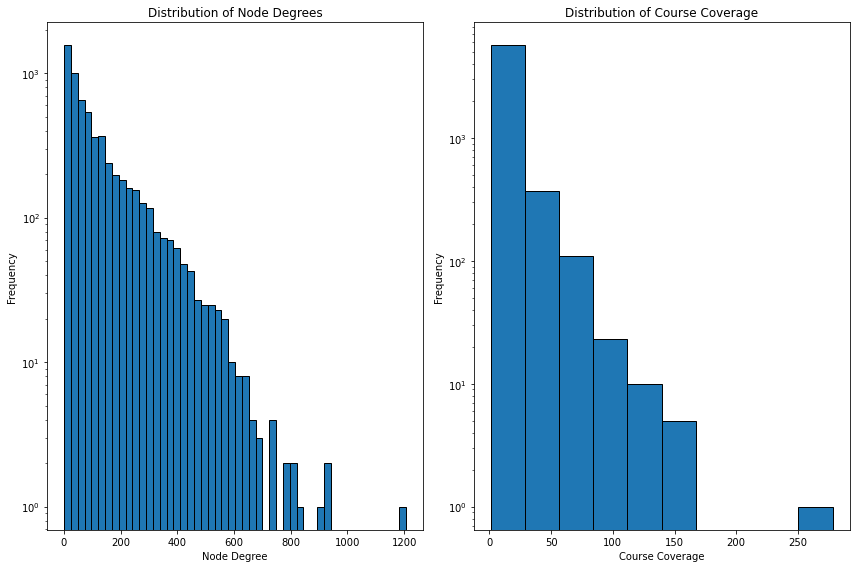

In [41]:
# Calculate the degree of each node in the graph
degree = dict(G.degree())
degrees = list(degree.values())

course_coverage = [G.nodes[node]['course_coverage'] for node in G.nodes() if 'course_coverage' in G.nodes[node]]

# Create a histogram of node degrees
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)  # Create the first subplot
plt.hist(degrees, bins=50, edgecolor='k')
plt.title('Distribution of Node Degrees')
plt.xlabel('Node Degree')
plt.ylabel('Frequency')
plt.yscale('log')  # Set the y-axis to a logarithmic scale

# Create a histogram of course_coverage
plt.subplot(1, 2, 2)  # Create the second subplot
plt.hist(course_coverage, edgecolor='k')
plt.title('Distribution of Course Coverage')
plt.xlabel('Course Coverage')
plt.ylabel('Frequency')
plt.yscale('log')  # Set the y-axis to a logarithmic scale

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()

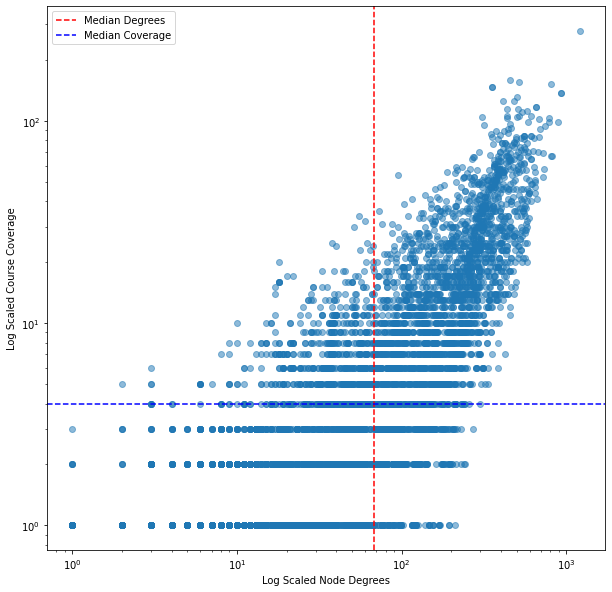

In [46]:
plt.figure(figsize=(10, 10))  # Adjust the figure size to (12, 12)
plt.scatter(degrees, course_coverage, alpha=0.5)

# Set the x-axis and y-axis to log scale
plt.xscale('log')
plt.yscale('log')

plt.xlabel("Log Scaled Node Degrees")
plt.ylabel("Log Scaled Course Coverage")

median_degree = np.median(degrees)
median_coverage = np.median(course_coverage)

# Draw axlines for median values
plt.axvline(median_degree, color='red', linestyle='--', label='Median Degrees')
plt.axhline(median_coverage, color='blue', linestyle='--', label='Median Coverage')

plt.legend()

plt.savefig('log-log plot for degree and coverage.png', bbox_inches='tight')
plt.show()

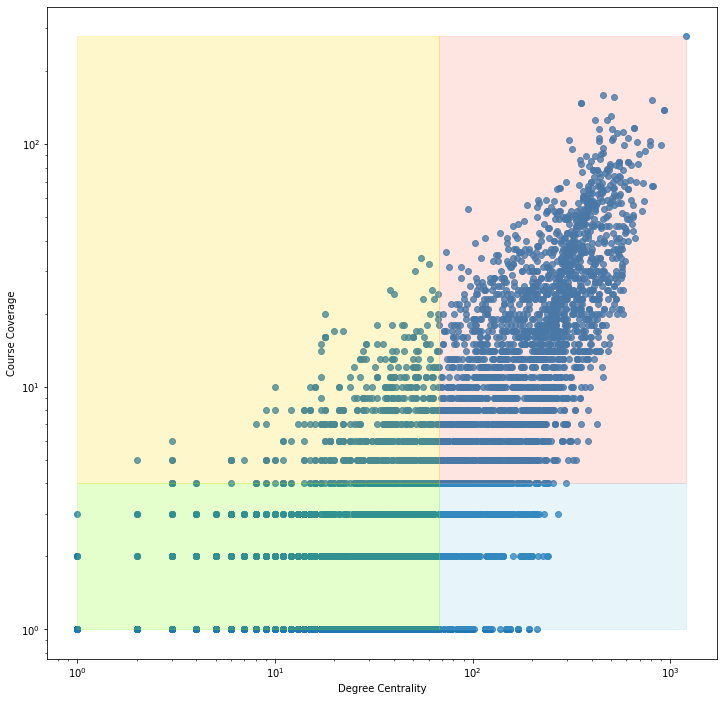

In [73]:
# Calculate the medians
median_degrees = np.median(degrees)
median_coverage = np.median(course_coverage)

# Create a scatter plot with log-scaled axes
plt.figure(figsize=(12, 12))
plt.scatter(degrees, course_coverage, alpha=0.8)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree Centrality")
plt.ylabel("Course Coverage")

# Define the coordinates of the corners of each quadrant
quadrant1_x = [median_degrees, max(degrees)]
quadrant1_y = [median_coverage, max(course_coverage)]
quadrant2_x = [median_degrees, max(degrees)]
quadrant2_y = [min(course_coverage), median_coverage]
quadrant3_x = [min(degrees), median_degrees]
quadrant3_y = [median_coverage, max(course_coverage)]
quadrant4_x = [min(degrees), median_degrees]
quadrant4_y = [min(course_coverage), median_coverage]

# Fill the quadrants with different colors
plt.fill_between(quadrant1_x, quadrant1_y[0], quadrant1_y[1], color='salmon', alpha=0.2)
plt.fill_between(quadrant2_x, quadrant2_y[0], quadrant2_y[1], color='skyblue', alpha=0.2)
plt.fill_between(quadrant3_x, quadrant3_y[0], quadrant3_y[1], color='gold', alpha=0.2)
plt.fill_between(quadrant4_x, quadrant4_y[0], quadrant4_y[1], color='lawngreen', alpha=0.2)
plt.savefig('log-log plot for degree and coverage.png', bbox_inches='tight')
# Show the plot
plt.show()

In [483]:
# Initialize a dictionary to store the sum of shortest path lengths for each label pair
label_pairs = set(nx.get_node_attributes(G, 'label').values())
shortest_path_sum = {pair: 0 for pair in label_pairs}
count = {pair: 0 for pair in label_pairs}

# Calculate the shortest path lengths and sum them for each label pair
for source in G.nodes():
    for target in G.nodes():
        if source != target and G.nodes[source]['label'] == G.nodes[target]['label']:
            if nx.has_path(G, source, target):
                shortest_path_length = nx.shortest_path_length(G, source=source, target=target)
                shortest_path_sum[G.nodes[source]['label']] += shortest_path_length
                count[G.nodes[source]['label']] += 1

In [ ]:
# Initialize variables to store the sum and count of shortest path lengths for the entire graph
total_shortest_path_sum = 0
total_count = 0

# Calculate the sum and count for each connected pair of nodes
for source in G.nodes():
    for target in G.nodes():
        if source != target and nx.has_path(G, source, target):
            shortest_path_length = nx.shortest_path_length(G, source=source, target=target)
            total_shortest_path_sum += shortest_path_length
            total_count += 1

# Calculate the average shortest path length for the entire graph
average_shortest_path = total_shortest_path_sum / total_count if total_count != 0 else 0

print("Average Shortest Path for the Entire Graph:", average_shortest_path)

In [484]:
# Initialize a dictionary to store the average shortest path lengths for each label pair
average_shortest_path = {pair: shortest_path_sum[pair] / count[pair] if count[pair] != 0 else 0 for pair in label_pairs}

# Convert the dictionary to a DataFrame
avg_path_df = pd.DataFrame(list(average_shortest_path.items()), columns=['Label', 'Average Shortest Path'])

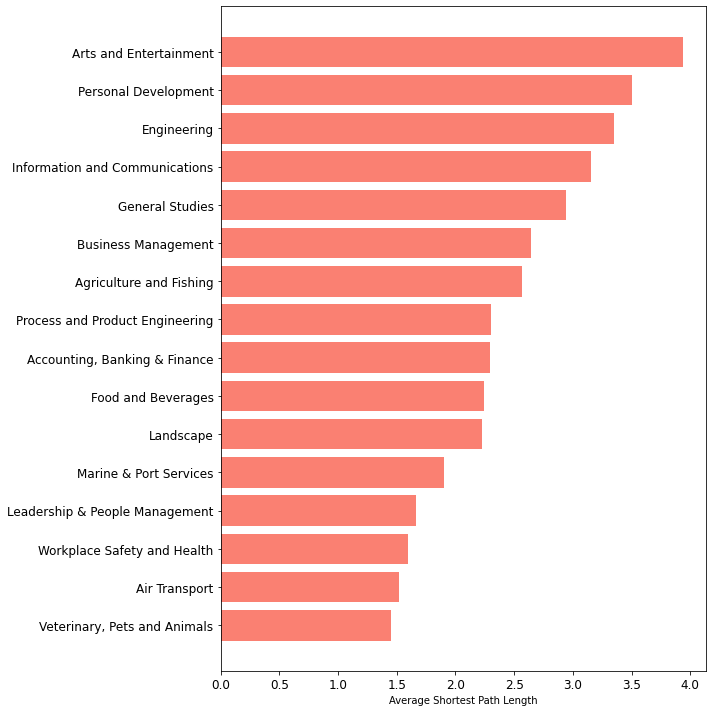

In [485]:
# Select only the specified categories
selected_categories = [
    "Air Transport",
    "Personal Development",
    "Engineering",
    "Business Management",
    "Information and Communications",
    "Agriculture and Fishing",
    "Workplace Safety and Health",
    "Arts and Entertainment",
    "Marine & Port Services",
    "Leadership & People Management",
    "Accounting, Banking & Finance",
    "Process and Product Engineering",
    "Veterinary, Pets and Animals",
    "Food and Beverages",
    "General Studies",
    "Landscape"
]

df_selected = avg_path_df[avg_path_df['Label'].isin(selected_categories)]
df_selected = df_selected.sort_values(by='Average Shortest Path', ascending=True)

# Plotting with switched axes using barh
plt.figure(figsize=(10, 10))
plt.barh(df_selected['Label'], df_selected['Average Shortest Path'], color='salmon')
plt.xlabel('Average Shortest Path Length')
plt.xticks(fontsize=12)  # Adjust font size for x-axis tick labels
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('avg path length rankplot.png', bbox_inches='tight')

# Show the plot
plt.show()

In [94]:
# Calculate the average shortest path length for each label only if count is non-zero
average_shortest_path_length = {label: shortest_path_sum[label] / count[label] if count[label] > 0 else 0 for label in label_pairs}

# Sort the results in descending order (from many to little)
sorted_results = sorted(average_shortest_path_length.items(), key=lambda x: x[1], reverse=False)

# Print the sorted results
for label, avg_length in sorted_results:
    print(f'Average shortest path length for label {label}: {avg_length}')

Average shortest path length for label Graphic Reproduction/Offset Printing/Mechanised Bookbinding: 0
Average shortest path length for label Insurance: 0
Average shortest path length for label Language Skills: 1.3125
Average shortest path length for label Veterinary, Pets and Animals: 1.4509803921568627
Average shortest path length for label Air Transport: 1.523076923076923
Average shortest path length for label Service Excellence: 1.5807692307692307
Average shortest path length for label Workplace Safety and Health: 1.600111828394246
Average shortest path length for label Leadership & People Management: 1.6625537139349293
Average shortest path length for label Marine & Port Services: 1.904176904176904
Average shortest path length for label Procurement/Purchasing: 1.9696969696969697
Average shortest path length for label Security and Investigation: 2.0033562166285277
Average shortest path length for label Human Resource Management, Employment and Recruitment: 2.0047351287363124
Average

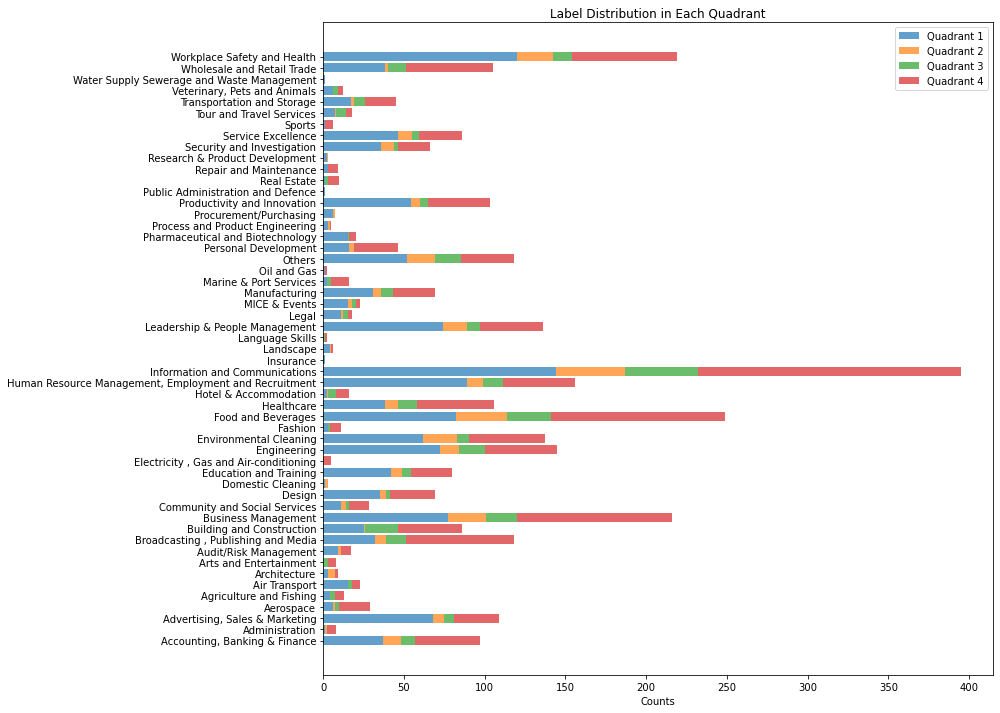

In [42]:
# Define the conditions for each quadrant
quadrant1_condition = (np.array(degrees) > median_degrees) & (np.array(course_coverage) > median_coverage)
quadrant2_condition = (np.array(degrees) > median_degrees) & (np.array(course_coverage) < median_coverage)
quadrant3_condition = (np.array(degrees) < median_degrees) & (np.array(course_coverage) > median_coverage)
quadrant4_condition = (np.array(degrees) < median_degrees) & (np.array(course_coverage) < median_coverage)

# Assuming your graph 'G' has node labels as course names or identifiers, extract labels for each quadrant
# Extract labels for each quadrant
# Extract labels for each quadrant, filtering out nodes with None labels
quadrant1_labels = [G.nodes[node]['label'] for node, condition in enumerate(quadrant1_condition) if condition and node in G and G.nodes[node]['label'] is not None]
quadrant2_labels = [G.nodes[node]['label'] for node, condition in enumerate(quadrant2_condition) if condition and node in G and G.nodes[node]['label'] is not None]
quadrant3_labels = [G.nodes[node]['label'] for node, condition in enumerate(quadrant3_condition) if condition and node in G and G.nodes[node]['label'] is not None]
quadrant4_labels = [G.nodes[node]['label'] for node, condition in enumerate(quadrant4_condition) if condition and node in G and G.nodes[node]['label'] is not None]

# Create a dictionary to count label occurrences in each quadrant
def count_labels(labels):
    label_counts = {}
    for label in labels:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1
    return label_counts

quadrant1_label_counts = count_labels(quadrant1_labels)
quadrant2_label_counts = count_labels(quadrant2_labels)
quadrant3_label_counts = count_labels(quadrant3_labels)
quadrant4_label_counts = count_labels(quadrant4_labels)

# Create stacked bar charts for label distribution in each quadrant
labels = set(quadrant1_labels + quadrant2_labels + quadrant3_labels + quadrant4_labels)
labels = sorted(labels)  # Sort the labels for consistency

# Extract label counts for all quadrants
counts_quadrant1 = [quadrant1_label_counts.get(label, 0) for label in labels]
counts_quadrant2 = [quadrant2_label_counts.get(label, 0) for label in labels]
counts_quadrant3 = [quadrant3_label_counts.get(label, 0) for label in labels]
counts_quadrant4 = [quadrant4_label_counts.get(label, 0) for label in labels]

# Create a stacked bar chart with labels on the x-axis and counts on the y-axis
plt.figure(figsize=(12, 12))
plt.barh(labels, counts_quadrant1, label='Quadrant 1', alpha=0.7)
plt.barh(labels, counts_quadrant2, left=counts_quadrant1, label='Quadrant 2', alpha=0.7)
plt.barh(labels, counts_quadrant3, left=np.array(counts_quadrant1) + np.array(counts_quadrant2), label='Quadrant 3', alpha=0.7)
plt.barh(labels, counts_quadrant4, left=np.array(counts_quadrant1) + np.array(counts_quadrant2) + np.array(counts_quadrant3), label='Quadrant 4', alpha=0.7)

plt.xlabel('Counts')
plt.title('Label Distribution in Each Quadrant')
plt.legend()

plt.show()

In [ ]:
# Calculate the total counts in each quadrant
total_counts = np.array(counts_quadrant3) + np.array(counts_quadrant1) + np.array(counts_quadrant2) + np.array(counts_quadrant4)

# Calculate proportions for each quadrant
proportions_quadrant1 = np.array(counts_quadrant1) / total_counts
proportions_quadrant2 = np.array(counts_quadrant2) / total_counts
proportions_quadrant3 = np.array(counts_quadrant3) / total_counts
proportions_quadrant4 = np.array(counts_quadrant4) / total_counts

# Sort labels based on the proportion in Quadrant 1
sorted_labels = [label for _, label in sorted(zip(proportions_quadrant3, labels), reverse=False)]

# Sort proportions accordingly
sorted_proportions_quadrant1 = np.array([proportions_quadrant1[labels.index(label)] for label in sorted_labels])
sorted_proportions_quadrant2 = np.array([proportions_quadrant2[labels.index(label)] for label in sorted_labels])
sorted_proportions_quadrant3 = np.array([proportions_quadrant3[labels.index(label)] for label in sorted_labels])
sorted_proportions_quadrant4 = np.array([proportions_quadrant4[labels.index(label)] for label in sorted_labels])

# Create a dictionary to map quadrant numbers to colors
quadrant_colors = {
    1: 'salmon',
    2: 'skyblue',
    3: 'limegreen',
    4: 'gold'
}

# Create a horizontal stacked bar chart with sorted labels and colors
width = 0.35  # Width of each bar

y = np.arange(len(sorted_labels))  # Label positions on the y-axis

plt.figure(figsize=(12, 12))

# Use the quadrant_colors dictionary to set colors for each quadrant
plt.barh(y, sorted_proportions_quadrant3, height=width, label='High Demand Low Supply', color=quadrant_colors[3], alpha=0.5)
plt.barh(y, sorted_proportions_quadrant1, height=width, label='High Demand High Supply', color=quadrant_colors[1], alpha=0.5, left=sorted_proportions_quadrant3)
plt.barh(y, sorted_proportions_quadrant2, height=width, label='Low Demand High supply', color=quadrant_colors[2], alpha=0.5, left=sorted_proportions_quadrant3 + sorted_proportions_quadrant1)
plt.barh(y, sorted_proportions_quadrant4, height=width, label='Low Demand Low supply', color=quadrant_colors[4], alpha=0.5, left=sorted_proportions_quadrant3 + sorted_proportions_quadrant1 + sorted_proportions_quadrant2)

plt.xlabel('Proportion in Quadrants')
plt.yticks(y, sorted_labels)
plt.legend()

plt.show()

In [42]:
B = nx.Graph()

# Assuming course_names and skill_names are lists of course and skill names
course_names = combined_df.index
skill_names = combined_df.columns

B.add_nodes_from(course_names, bipartite=0)  # Courses are in partition 0
B.add_nodes_from(skill_names, bipartite=1)   # Skills are in partition 1

In [43]:
for i in range(len(course_names)):
    course_name = course_names[i]
    for j in range(len(skill_names)):
        value = filtered_matrix[i, j]
        if value == 1:
            skill_name = skill_names[j]
            B.add_edge(course_name, skill_name)

In [44]:
labels_course = {node: row['course_label'] for node, row in df_course.set_index('id').iterrows()}
labels_skill = {node: row['skill_label'] for node, row in df_skill.set_index('id').iterrows()}
labels_job = {node: row['job_label'] for node, row in df_job.set_index('id').iterrows()}

In [45]:
# Set node attributes with condition based on bipartite attribute
for node in B.nodes():
    if B.nodes[node]['bipartite'] == 0:
        B.nodes[node]['label'] = labels_course.get(node, None)
    elif B.nodes[node]['bipartite'] == 1:
        B.nodes[node]['label'] = labels_skill.get(node, None) or labels_job.get(node, None)

In [46]:
# Convert the edge list to a DataFrame
edge_list = nx.to_pandas_edgelist(B)
kc0 = edge_list.groupby('source')['target'].count().reset_index()
kp0 = edge_list.groupby('target')['source'].count().reset_index()

In [47]:
# Step 1: Save kc0 in source nodes as 'kc0' attributes
for node, kc0_value in zip(kc0['source'], kc0['target']):
    if node in B.nodes:
        B.nodes[node]['kc0'] = kc0_value

# Step 2: Save kp0 in target nodes as 'kp0' attributes
for node, kp0_value in zip(kp0['target'], kp0['source']):
    if node in B.nodes:
        B.nodes[node]['kp0'] = kp0_value

In [48]:
# Loop for calculating kc1 to kc10
for iteration in range(1, 3):  # Assuming you want to calculate up to kc10

    # Calculate kc_i for each source node
    for source_node in B.nodes:
        neighbors = list(B.neighbors(source_node))

        # Sum kp(i-1) attributes of neighbors that have 'kp(i-1)' values
        kp_sum = sum(B.nodes[neighbor]['kp{}'.format(iteration-1)] for neighbor in neighbors
                     if 'kp{}'.format(iteration-1) in B.nodes[neighbor])

        # Divide the sum of kp0 attribute by inverse of kc0 of the source node
        if 'kc0' in B.nodes[source_node]:
            kc0_value = B.nodes[source_node]['kc0']
            B.nodes[source_node]['kc{}'.format(iteration)] = kp_sum / kc0_value

    # Calculate kp_i for each target node
    for target_node in B.nodes:
        source_node_neighbors = list(B.neighbors(target_node))

        # Sum kc(i) attributes of source node neighbors
        kc_sum = sum(B.nodes[source]['kc{}'.format(iteration-1)] for source in source_node_neighbors
                    if 'kc{}'.format(iteration-1) in B.nodes[source])

        # Divide the sum of kc(i) attribute by kpo of the target node
        if 'kp0' in B.nodes[target_node]:
            kp0_value = B.nodes[target_node]['kp0']
            B.nodes[target_node]['kp{}'.format(iteration)] = kc_sum / kp0_value

In [87]:
# Extract data from source nodes
source_data = {'Node': []}
for i in range(3):  # Assuming you want kc0 to kc10
    source_data[f'kc{i}'] = []

for node in B.nodes:
    source_data['Node'].append(node)
    for i in range(3):
        attribute_key = f'kc{i}'
        source_data[attribute_key].append(B.nodes[node].get(attribute_key, np.nan))

# Create a dataframe from the extracted data
kc_df = pd.DataFrame(source_data)
kc_df = kc_df.dropna()
kc_df

,Node,kc0,kc1,kc2
2,Certificate in Athlete Life Coaching,1.0,29.000000,4.586207
3,Certificate Course in 2nd Grade Computer Aided...,8.0,30.875000,7.374637
7,Certificate Course in 2nd Grade Engineering Ma...,3.0,4.333333,2.133333
8,Certificate Course in 1st Grade Engineering Kn...,1.0,2.000000,33.000000
9,Certificate Course in 1st Grade Engineering Ma...,2.0,5.500000,2.200000
...,...,...,...,...
13689,Audit Management I,10.0,12.500000,18.679067
13690,"""Think Out Of The Box"" (Synchronous e-Learning)",6.0,44.500000,25.000518
13692,Family Mediation Certification Programme (Modu...,1.0,13.000000,6.000000
13693,Family Mediation Certification Programme (Modu...,1.0,13.000000,6.000000


0.27219689725812674


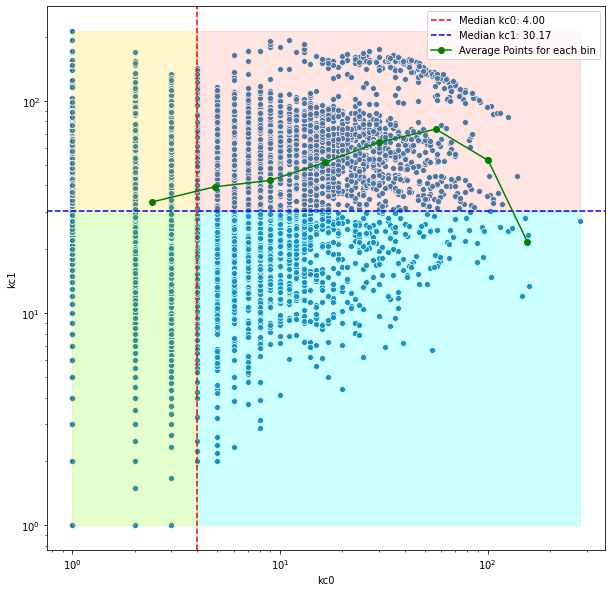

In [88]:
# Scatter plot for kc0-kc1 with log scale
plt.figure(figsize=(10, 10))
sns.scatterplot(x='kc0', y='kc1', data=kc_df)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('kc0')
plt.ylabel('kc1' )

# Add reference lines for medians
median_kc0 = kc_df['kc0'].median()
median_kc1 = kc_df['kc1'].median()
plt.axvline(median_kc0, color='red', linestyle='--', label=f'Median kc0: {median_kc0:.2f}')
plt.axhline(median_kc1, color='blue', linestyle='--', label=f'Median kc1: {median_kc1:.2f}')

# Calculate and display the correlation
correlation_coefficient = kc_df['kc0'].corr(kc_df['kc1'])
print(correlation_coefficient)

# Group by bins and calculate mean for each bin
bins = np.logspace(np.log10(kc_df['kc0'].min()), np.log10(kc_df['kc0'].max()), num=10)
kc_df['kc0_bins'] = pd.cut(kc_df['kc0'], bins=bins)
average_values = kc_df.groupby('kc0_bins').mean()

# Line plot connecting average points
plt.plot(average_values['kc0'], average_values['kc1'], marker='o', linestyle='-', color='green', label='Average Points for each bin')

# Color the quadrants
plt.fill_betweenx(y=[median_kc1, kc_df['kc1'].max()], x1=median_kc0, x2=kc_df['kc0'].max(), color='salmon', alpha=0.2)
plt.fill_betweenx(y=[kc_df['kc1'].min(), median_kc1], x1=median_kc0, x2=kc_df['kc0'].max(), color='cyan', alpha=0.2)
plt.fill_betweenx(y=[kc_df['kc1'].min(), median_kc1], x1=kc_df['kc0'].min(), x2=median_kc0, color='lawngreen', alpha=0.2)
plt.fill_betweenx(y=[median_kc1, kc_df['kc1'].max()], x1=kc_df['kc0'].min(), x2=median_kc0, color='gold', alpha=0.2)

# Save the scatter plot with the line plot
plt.savefig('kc0-kc1 scatterplot.png', bbox_inches='tight')

plt.legend()
plt.show()

In [91]:
# Left join result_df to linear_df
merged_df = pd.merge(kc_df, linear_df, left_on='Node', right_on='course_name', how='left')

# Drop duplicate columns (if needed)
#merged_df = merged_df.drop(columns=['course_name','job_entropy_value'])
merged_df = merged_df.dropna().reset_index()
merged_df = merged_df.drop(columns=['index'])
merged_df

,Node,kc0,kc1,kc2,kc0_bins,course_name,coverage,label,degree,course_impact
0,Certificate Course in 2nd Grade Computer Aided...,8.0,30.875000,7.374637,"(6.527, 12.197]",Certificate Course in 2nd Grade Computer Aided...,8.0,Engineering,78.0,0.102564
1,Certificate Course in 2nd Grade Engineering Ma...,3.0,4.333333,2.133333,"(1.869, 3.492]",Certificate Course in 2nd Grade Engineering Ma...,3.0,Engineering,7.0,0.428571
2,Certificate Course in 1st Grade Engineering Ma...,2.0,5.500000,2.200000,"(1.869, 3.492]",Certificate Course in 1st Grade Engineering Ma...,2.0,Engineering,6.0,0.333333
3,Joint ITE-UPEC Certificate in Pre-Hospital Eme...,10.0,30.100000,11.625168,"(6.527, 12.197]",Joint ITE-UPEC Certificate in Pre-Hospital Eme...,10.0,Healthcare,130.0,0.076923
4,FIRE SAFETY MANAGER COURSE,3.0,35.000000,23.412787,"(1.869, 3.492]",FIRE SAFETY MANAGER COURSE,3.0,Workplace Safety and Health,71.0,0.042254
...,...,...,...,...,...,...,...,...,...,...
4782,Good Dispensing Practice (part of PDC2 of Adva...,5.0,9.400000,9.201818,"(3.492, 6.527]",Good Dispensing Practice (part of PDC2 of Adva...,5.0,Pharmaceutical and Biotechnology,11.0,0.454545
4783,Drug Information (part of PDC2 of Advanced Dip...,4.0,10.750000,9.627273,"(3.492, 6.527]",Drug Information (part of PDC2 of Advanced Dip...,4.0,Pharmaceutical and Biotechnology,11.0,0.363636
4784,Audit Management I,10.0,12.500000,18.679067,"(6.527, 12.197]",Audit Management I,10.0,Healthcare,52.0,0.192308
4785,"""Think Out Of The Box"" (Synchronous e-Learning)",6.0,44.500000,25.000518,"(3.492, 6.527]","""Think Out Of The Box"" (Synchronous e-Learning)",6.0,Productivity and Innovation,134.0,0.044776


In [92]:
median_kc = merged_df.groupby('label')[['kc0','kc1','kc2','course_impact']].median().reset_index()

# Count the number of courses in each group
course_counts = merged_df['label'].value_counts().reset_index()
course_counts.columns = ['label', 'course_count']

# Merge the median_kc DataFrame with course_counts
median_kc = pd.merge(median_kc, course_counts, on='label')

# Filter out groups with counts under 10
median_kc_filtered = median_kc[median_kc['course_count'] >= 5]
median_kc_filtered = median_kc_filtered.drop('course_count', axis=1)

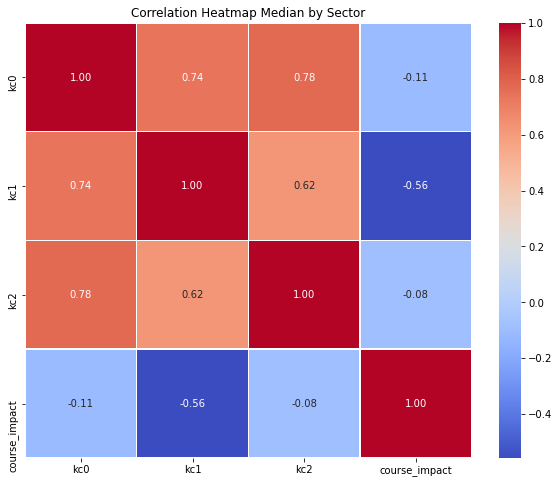

In [93]:
##### Calculate correlation matrix
correlation_matrix = median_kc_filtered.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap Median by Sector')

plt.savefig('kcvalues_sector_median.png', bbox_inches='tight')

plt.show()

In [ ]:
# Sort the DataFrame for each key component
df_sorted_coverage = median_kc_filtered.sort_values(by='coverage', ascending=False)
df_sorted_kc10 = median_kc_filtered.sort_values(by='kc10', ascending=False)
df_sorted_kc20 = median_kc_filtered.sort_values(by='kc20', ascending=False)
df_sorted_kc40 = median_kc_filtered.sort_values(by='kc40', ascending=False)
df_sorted_kc60 = median_kc_filtered.sort_values(by='kc60', ascending=False)
df_sorted_kc80 = median_kc_filtered.sort_values(by='kc80', ascending=False)
df_sorted_kc100 = median_kc_filtered.sort_values(by='kc100', ascending=False)
df_sorted_kc200 = median_kc_filtered.sort_values(by='kc200', ascending=False)

# Get the ranking positions for each key component label
rankings_coverage = {label: rank for rank, label in enumerate(df_sorted_coverage['label'])}
rankings_kc10 = {label: rank for rank, label in enumerate(df_sorted_kc10['label'])}
rankings_kc20 = {label: rank for rank, label in enumerate(df_sorted_kc20['label'])}
rankings_kc40 = {label: rank for rank, label in enumerate(df_sorted_kc40['label'])}
rankings_kc60 = {label: rank for rank, label in enumerate(df_sorted_kc60['label'])}
rankings_kc80 = {label: rank for rank, label in enumerate(df_sorted_kc80['label'])}
rankings_kc100 = {label: rank for rank, label in enumerate(df_sorted_kc100['label'])}
rankings_kc200 = {label: rank for rank, label in enumerate(df_sorted_kc200['label'])}


# Define a custom color palette
colors = sns.color_palette("husl", n_colors=len(median_kc_filtered))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 12))

# Plot lines for coverage, kc2, kc4, kc6, kc8, kc10, kc12, kc14, kc16, kc18, and kc20 rankings with different colors
for i, (label, rank) in enumerate(rankings_coverage.items()):
    coverage_rank = rankings_coverage[label]
    kc10_rank = rankings_kc10[label]
    kc20_rank = rankings_kc20[label]
    kc40_rank = rankings_kc40[label]
    kc60_rank = rankings_kc60[label]
    kc80_rank = rankings_kc80[label]
    kc100_rank = rankings_kc100[label]
    kc200_rank = rankings_kc200[label]
    
    label_color = colors[i]

    ax.plot(
        [0, 1, 2, 3, 4, 5, 6, 7],
        [coverage_rank, kc10_rank, kc20_rank, kc40_rank, kc60_rank, kc80_rank, kc100_rank, kc200_rank],
        marker='o', label=label, color=label_color
    )

# Set x-axis labels
ax.set_xticks(list(range(8)))
ax.set_xticklabels(['coverage', 'kc10', 'kc20', 'kc40', 'kc60', 'kc80', 'kc100','kc200'])

# Set y-axis labels and limits
ax.set_yticks(range(len(median_kc_filtered)))
ax.set_yticklabels(df_sorted_coverage['label'])  # Use the coverage order
ax.invert_yaxis()  # Invert the y-axis to have lower rankings at the top

# Save the plot as a PNG file
plt.savefig('kcvalues_ranking.png', bbox_inches='tight')

plt.show()

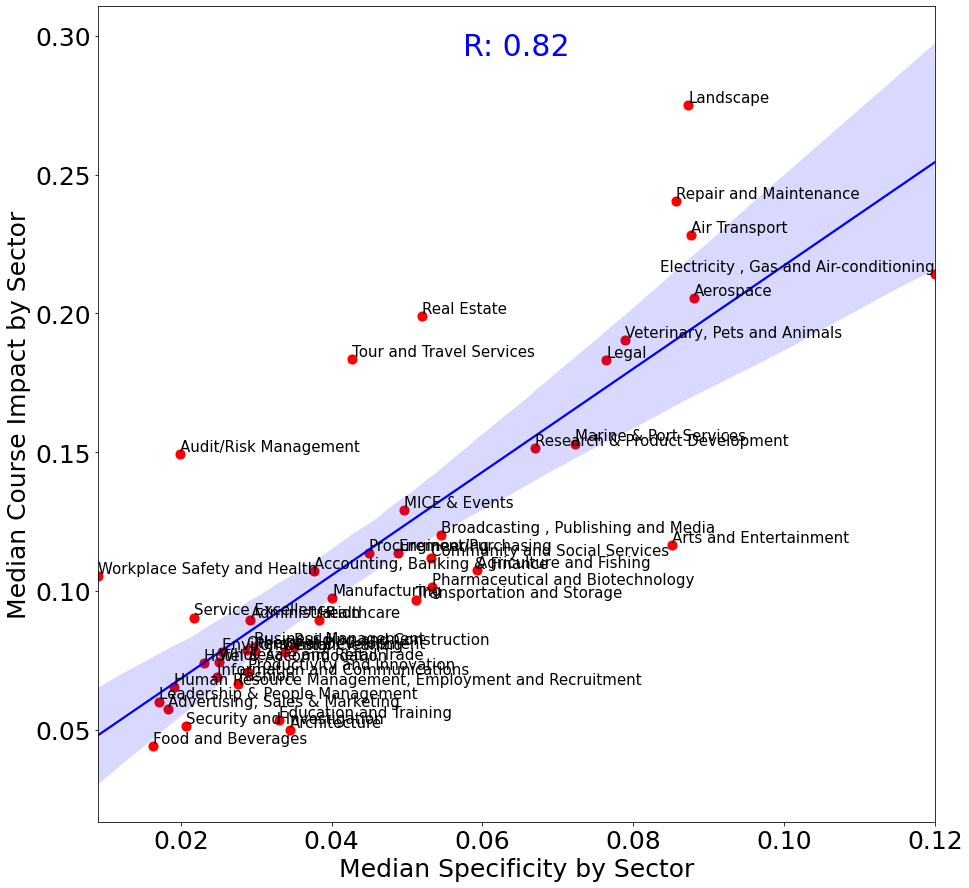

In [94]:
# Calculate the inverse of kc1
median_kc_filtered['inverse_kc1'] = 1 / median_kc_filtered['kc1']

# Create a scatter plot
plt.figure(figsize=(15, 15))
sns.scatterplot(x='inverse_kc1', y='course_impact', data=median_kc_filtered, color='red', s=120)

# Draw a fitted line (regression line)
sns.regplot(x='inverse_kc1', y='course_impact', data=median_kc_filtered, scatter=False, color='blue')

# Calculate the correlation coefficient'b
correlation_coefficient_inverse_kc1 = median_kc_filtered['inverse_kc1'].corr(median_kc_filtered['course_impact'])

# Annotate each point with its corresponding label
for label, x, y in zip(median_kc_filtered['label'], median_kc_filtered['inverse_kc1'], median_kc_filtered['course_impact']):
    ha_value = 'left' if label != 'Electricity , Gas and Air-conditioning' else 'right'
    plt.text(x, y, label, fontsize=15, ha=ha_value,va='bottom', color='black')

    
# Annotate the plot with the correlation coefficient
plt.annotate(f'R: {correlation_coefficient_inverse_kc1:.2f}',
             xy=(0.5, 0.95), xycoords='axes fraction',
             ha='center', va='center', fontsize=30, color='blue')

# Set x-axis limits
plt.xlabel('Median Specificity by Sector', fontsize=25)
plt.ylabel('Median Course Impact by Sector', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.savefig('Speciality_Impact_scatter.png', bbox_inches='tight', dpi=300)

plt.show()

In [71]:
median_kc_filtered.to_csv('course_impact-specificity.csv')

In [86]:
# Check if the graph is bipartite
if nx.is_bipartite(B):
    # Get the nodes in each partition
    course_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}
    skill_nodes = set(B) - course_nodes

    # Print the number of nodes in each partition
    print("Number of course nodes:", len(course_nodes))
    print("Number of skill nodes:", len(skill_nodes))

Number of course nodes: 13695
Number of skill nodes: 4036


In [221]:
green_economy = pd.read_csv('Green Economy.csv')
green_economy = green_economy.rename(columns={'Title of Priority Skill':'TSC_CCS Title','Description of Priority Skill':'TSC_CCS Description'})

def percentage_to_float(percentage_str):
    return float(percentage_str.strip('%'))

# Apply the function to the DataFrame
green_economy['Demand Growth'] = green_economy['Demand Growth'].apply(percentage_to_float)
green_economy['label'] = 'green_economy'
green_economy.head()

,Emerging Domain,TSC_CCS Title,TSC_CCS Description,Demand Growth,Transferability,No. of Job Posts in 2021 Requiring this Skill,label
0,"Energy, Resource Circularity and Decarbonisation",Smart Grid Implementation and Integration,"Apply knowledge of smart grid architecture, Su...",71.0,4,5,green_economy
1,"Energy, Resource Circularity and Decarbonisation",Energy Management and Audit,Perform energy audits to optimise the energy p...,74.3,413,4303,green_economy
2,"Energy, Resource Circularity and Decarbonisation",Agriculture and Aquaculture Technology Impleme...,Integrate and deploy emerging agriculture and/...,100.0,2,2,green_economy
3,"Energy, Resource Circularity and Decarbonisation",Urban Farming Business Development and Management,Apply knowledge of urban farming techniques to...,108.0,12,27,green_economy
4,"Energy, Resource Circularity and Decarbonisation",Waste Disposal Management,Manage the waste disposal process including th...,111.3,157,774,green_economy


In [222]:
green_skill = pd.merge(green_economy, df_skill, on=['TSC_CCS Title','TSC_CCS Description'], how='left')
green_skill = green_skill.dropna()

green_skill = green_skill[['id','label','TSC_CCS Title','TSC_CCS Description','Transferability']]
green_skill

,id,label,TSC_CCS Title,TSC_CCS Description,Transferability
1,EPW-AUD-3012-1.1,green_economy,Energy Management and Audit,Perform energy audits to optimise the energy p...,413
4,EVS-WMO-1003-1.1,green_economy,Waste Disposal Management,Manage the waste disposal process including th...,157
6,EPW-ETM-4001-1.1,green_economy,Energy Trading Portfolio Optimisation,Formulate portfolio optimisation strategies to...,4
9,BEV-EPM-2058-1.1,green_economy,Solar Photovoltaic Systems Designs,Oversee design of solar Photovoltaic (PV) syst...,11
10,FSS-SPI-3012-1.1,green_economy,Sustainable Food Production Design,Design and implement sustainable food producti...,87
12,BPM-ENM-3013-1.1,green_economy,Utilities Management,Develop plans to meet manufacturing utilities ...,21
17,BEV-EPM-3057-1.1,green_economy,Solar Photovoltaic Energy Assessment,Assess feasibility of solar Photovoltaic (PV) ...,23
18,EGS-EPM-3065-1.1,green_economy,Sustainable Engineering,"Design, construct and operate engineering syst...",199
19,FIN-SUS-3012-1.1,green_economy,Climate Change Management,Synthesise information on climate change and c...,18
20,ICT-SNA-4022-1.1,green_economy,Sustainability Management,"Plan, develop and roll out of an organisation-...",267


In [223]:
skills_data = green_skill.set_index('id')['Transferability'].to_dict()

In [224]:
# Assign values from skills_data to partition 1 nodes
for skill_name in skill_names:
    if skill_name in skills_data:
        value = skills_data[skill_name]
        B.nodes[skill_name]['green_transferability'] = value  # Add 'value' attribute to the node

In [626]:
# Iterate through the skill nodes in partition 1 with transferability values and count their course neighbors
for skill_node in skill_names:
    if 'green_transferability' in B.nodes[skill_node]:
        transferability_value = B.nodes[skill_node]['green_transferability']

        # Get the course neighbors of the skill node
        course_neighbors = [node for node in B.neighbors(skill_node) if B.nodes[node]['bipartite'] == 0]
        num_course_neighbors = len(course_neighbors)

        print(f"Skill Node: {skill_node}, Transferability: {transferability_value} ,Course Neighbors: {num_course_neighbors}")

Skill Node: ACC-PVE-3012-1.1, Transferability: 296 ,Course Neighbors: 9
Skill Node: AER-ENV-4001-1.1, Transferability: 181 ,Course Neighbors: 7
Skill Node: AER-MPR-3012-1.1-1, Transferability: 13 ,Course Neighbors: 7
Skill Node: BPM-ENM-3013-1.1, Transferability: 21 ,Course Neighbors: 2
Skill Node: BEV-DES-1053-1.1, Transferability: 7 ,Course Neighbors: 2
Skill Node: BEV-EPM-2058-1.1, Transferability: 11 ,Course Neighbors: 13
Skill Node: BEV-ENV-2003-1.1, Transferability: 153 ,Course Neighbors: 19
Skill Node: BEV-ENV-1004-1.1, Transferability: 7 ,Course Neighbors: 1
Skill Node: BEV-EPM-3057-1.1, Transferability: 23 ,Course Neighbors: 4
Skill Node: BEV-MAI-1091-1.1, Transferability: 39 ,Course Neighbors: 5
Skill Node: DSN-PVE-3011-1.1, Transferability: 27 ,Course Neighbors: 13
Skill Node: ECM-HSE-1001-1.1, Transferability: 142 ,Course Neighbors: 12
Skill Node: EPW-AUD-3012-1.1, Transferability: 413 ,Course Neighbors: 10
Skill Node: EPW-ETM-4001-1.1, Transferability: 4 ,Course Neighbors:

In [225]:
# Create a dictionary to store the total node sizes for each course node
green_course_sizes = {}

# Iterate through the course nodes
for course_node in course_names:
    total_size = 0

    # Get the skill node neighbors of the course node
    skill_neighbors = [neighbor_node for neighbor_node in B.neighbors(course_node) if B.nodes[neighbor_node]['bipartite'] == 1]

    for skill_node in skill_neighbors:
        if 'green_transferability' in B.nodes[skill_node]:
            # Correctly accumulate the transferability_value
            transferability_value = B.nodes[skill_node]['green_transferability']
            total_size += transferability_value

    # Store the total size for the course node
    green_course_sizes[course_node] = total_size

In [ ]:
# Iterate through course_sizes and print the total_size for courses with non-zero total_size
#for course_node, total_size in green_course_sizes.items():
#    if total_size > 0:
#        print(f"Course Node: {course_node}, Total Size: {total_size}")

In [226]:
# Assign 'green_transferability' attribute to the nodes in G
for course_node, green_transferability in green_course_sizes.items():
    # Check if the course node is in G based on the 'name' attribute
    nodes_with_name = [node for node in G.nodes if 'name' in G.nodes[node] and G.nodes[node]['name'] == course_node]
    if nodes_with_name:
        G.nodes[nodes_with_name[0]]['green_transferability'] = green_transferability

In [227]:
digital_economy = pd.read_csv('Digital Economy.csv')
digital_economy = digital_economy.rename(columns={'Title of Priority Skill':'TSC_CCS Title','Description of Priority Skill':'TSC_CCS Description'})

def percentage_to_float(percentage_str):
    return float(percentage_str.strip('%'))

# Apply the function to the DataFrame
digital_economy['Demand Growth'] = digital_economy['Demand Growth'].apply(percentage_to_float)
digital_economy['label'] = 'digital_economy'

digital_skill = pd.merge(digital_economy, df_skill, on=['TSC_CCS Title','TSC_CCS Description'], how='left')
digital_skill = digital_skill.dropna()

digital_skill = digital_skill[['id','label','TSC_CCS Title','TSC_CCS Description','Transferability']]
digital_skill

,id,label,TSC_CCS Title,TSC_CCS Description,Transferability
0,BPM-QUA-2001-1.1,digital_economy,Analytical Method Validation,Verify analytical methods used to ensure accur...,26
1,AER-TEM-3026-1.1,digital_economy,Artificial Intelligence Application,"Apply algorithmic, statistical and engineering...",760
2,ICT-CGP-2026-1.1,digital_economy,Artificial Intelligence Ethics and Governance,Establish and drive Artificial Intelligence Et...,20
3,INP-BIN-2104-1.1,digital_economy,Business Data Analysis,Implementing data analytics within the organis...,104
4,MED-ACE-4010-1.1,digital_economy,Business Insights,Define and operationalise business metrics and...,473
...,...,...,...,...,...
207,EPW-TEM-2023-1.1,digital_economy,Technology and Systems Application,Apply and integrate evaluated technologies int...,138
208,ATP-TEM-1003-1.1,digital_economy,Technology Application,Integrate technologies into operations of the ...,359
209,BEV-ICT-2001-1.1-1,digital_economy,Technology Scanning,Review new developments in emerging technology...,486
211,PRE-CTS-2002-1.1,digital_economy,Virtual Reality Application,Employ the use of virtual reality technology i...,222


In [228]:
care_economy = pd.read_csv('Care Economy.csv')
care_economy = care_economy.rename(columns={'Title of Priority Skill':'TSC_CCS Title','Description of Priority Skill':'TSC_CCS Description'})

def percentage_to_float(percentage_str):
    return float(percentage_str.strip('%'))

# Apply the function to the DataFrame
care_economy['Demand Growth'] = care_economy['Demand Growth'].apply(percentage_to_float)
care_economy['label'] = 'care_economy'

care_skill = pd.merge(care_economy, df_skill, on=['TSC_CCS Title','TSC_CCS Description'], how='left')
care_skill = care_skill.dropna()

care_skill = care_skill[['id','label','TSC_CCS Title','TSC_CCS Description','Transferability']]
care_skill

,id,label,TSC_CCS Title,TSC_CCS Description,Transferability
0,ECC-PPR-2020-1.1,care_economy,Collaborative Practices with Stakeholders Acro...,"Analyse services, contributions and perspectiv...",2
1,ACC-BRL-2001-1.1,care_economy,Conflict Management,"Build consensus, maintain the best interests o...",358
2,HRS-HRM-3017-1.1,care_economy,Employee Relationship Management,Strengthen employee relationships and facilita...,206
3,HRS-HRM-2016-1.1,care_economy,Employee Engagement Management,Drive employee engagement programmes to facili...,429
4,ECC-DCH-1004-1.1-1,care_economy,Family and Caregiver Engagement,Recognise the central role of the family in ev...,12
...,...,...,...,...,...
91,SSC-LDD-5022-1.1,care_economy,Learning Programme Design,Plan and design learning experiences that are ...,45
92,SSC-RND-2020-1.1,care_economy,Trends Evaluation and Application,Keep abreast of current developments and trend...,8
93,HRS-PDV-3023-1.1,care_economy,Career Coaching,Provide career coaching programmes to develop ...,433
94,HRS-PDV-3025-1.1,care_economy,Competency Framework Development,Design and develop competency frameworks withi...,24


In [229]:
i40_economy = pd.read_csv('I4.0 Economy.csv')
i40_economy = i40_economy.rename(columns={'Title of Priority Skill':'TSC_CCS Title','Description of Priority Skill':'TSC_CCS Description'})

def percentage_to_float(percentage_str):
    return float(percentage_str.strip('%'))

# Apply the function to the DataFrame
i40_economy['Demand Growth'] = i40_economy['Demand Growth'].apply(percentage_to_float)
i40_economy['label'] = 'i40_economy'

i40_skill = pd.merge(i40_economy, df_skill, on=['TSC_CCS Title','TSC_CCS Description'], how='left')
i40_skill = i40_skill.dropna()

i40_skill = i40_skill[['id','label','TSC_CCS Title','TSC_CCS Description','Transferability']]
i40_skill

,id,label,TSC_CCS Title,TSC_CCS Description,Transferability
0,BEV-DES-2032-1.1,i40_economy,3D Modelling,Generate 3D models using a variety of modellin...,244
1,AER-OPR-2012-1.1,i40_economy,Additive Manufacturing,Design and apply additive manufacturing workfl...,193
5,BEV-DES-2046-1.1,i40_economy,Architecture Design,Utilise holistic design approaches for the con...,309
6,AER-ACO-1032-1.1,i40_economy,Chemical Processing,Perform chemical processing applications on pa...,85
7,AER-ACO-1033-1.1,i40_economy,Coating,Perform surface coating processes on parts and...,11
...,...,...,...,...,...
138,EPW-EPM-3056-1.1,i40_economy,Site and Factory Acceptance Testing Management,Review factory audits and witness type tests t...,124
139,EPW-MPR-2030-1.1,i40_economy,Steam and Water Quality Control Management,Manage overall water quality control in power ...,25
140,FSS-SPI-1013-1.1,i40_economy,System and Work Process Improvement,Evaluate strategic and longer-term impacts of ...,241
141,BEV-QUA-2021-1.1-1,i40_economy,Technical Inspection,Execute formal inspection exercises to ensure ...,32


In [230]:
skills_digital = digital_skill.set_index('id')['Transferability'].to_dict()
skills_care = care_skill.set_index('id')['Transferability'].to_dict()
skills_i40 = i40_skill.set_index('id')['Transferability'].to_dict()

In [231]:
# Assign values from skills_data to partition 1 nodes
for skill_name in skill_names:
    if skill_name in skills_digital:
        value = skills_digital[skill_name]
        B.nodes[skill_name]['digital_transferability'] = value  # Add 'value' attribute to the node
# Assign values from skills_data to partition 1 nodes
for skill_name in skill_names:
    if skill_name in skills_care:
        value = skills_care[skill_name]
        B.nodes[skill_name]['care_transferability'] = value  # Add 'value' attribute to the node

        # Assign values from skills_data to partition 1 nodes
for skill_name in skill_names:
    if skill_name in skills_i40:
        value = skills_i40[skill_name]
        B.nodes[skill_name]['i40_transferability'] = value  # Add 'value' attribute to the node

In [232]:
# Create a dictionary to store the total node sizes for each course node
digital_course_sizes = {}

# Iterate through the course nodes
for course_node in course_names:
    total_size = 0

    # Get the skill node neighbors of the course node
    skill_neighbors = [neighbor_node for neighbor_node in B.neighbors(course_node) if B.nodes[neighbor_node]['bipartite'] == 1]

    for skill_node in skill_neighbors:
        if 'digital_transferability' in B.nodes[skill_node]:
            # Correctly accumulate the transferability_value
            transferability_value = B.nodes[skill_node]['digital_transferability']
            total_size += transferability_value

    # Store the total size for the course node
    digital_course_sizes[course_node] = total_size

# Assign 'digital_transferability' attribute to the nodes in G
for course_node, digital_transferability in digital_course_sizes.items():
    nodes_with_name = [node for node in G.nodes if 'name' in G.nodes[node] and G.nodes[node]['name'] == course_node]
    if nodes_with_name:
        G.nodes[nodes_with_name[0]]['digital_transferability'] = digital_transferability

In [233]:
# Create a dictionary to store the total node sizes for each course node
care_course_sizes = {}

# Iterate through the course nodes
for course_node in course_names:
    total_size = 0

    # Get the skill node neighbors of the course node
    skill_neighbors = [neighbor_node for neighbor_node in B.neighbors(course_node) if B.nodes[neighbor_node]['bipartite'] == 1]

    for skill_node in skill_neighbors:
        if 'care_transferability' in B.nodes[skill_node]:
            # Correctly accumulate the transferability_value
            transferability_value = B.nodes[skill_node]['care_transferability']
            total_size += transferability_value

    # Store the total size for the course node
    care_course_sizes[course_node] = total_size

# Assign 'care_transferability' attribute to the nodes in G
for course_node, care_transferability in care_course_sizes.items():
    nodes_with_name = [node for node in G.nodes if 'name' in G.nodes[node] and G.nodes[node]['name'] == course_node]
    if nodes_with_name:
        G.nodes[nodes_with_name[0]]['care_transferability'] = care_transferability

In [234]:
# Create a dictionary to store the total node sizes for each course node
i40_course_sizes = {}

# Iterate through the course nodes
for course_node in course_names:
    total_size = 0

    # Get the skill node neighbors of the course node
    skill_neighbors = [neighbor_node for neighbor_node in B.neighbors(course_node) if B.nodes[neighbor_node]['bipartite'] == 1]

    for skill_node in skill_neighbors:
        if 'i40_transferability' in B.nodes[skill_node]:
            # Correctly accumulate the transferability_value
            transferability_value = B.nodes[skill_node]['i40_transferability']
            total_size += transferability_value

    # Store the total size for the course node
    i40_course_sizes[course_node] = total_size

# Assign 'i40_transferability' attribute to the nodes in G
for course_node, i40_transferability in i40_course_sizes.items():
    nodes_with_name = [node for node in G.nodes if 'name' in G.nodes[node] and G.nodes[node]['name'] == course_node]
    if nodes_with_name:
        G.nodes[nodes_with_name[0]]['i40_transferability'] = i40_transferability

In [ ]:
##직업/스킬 카테고리에 대한 섀넌 엔트로피 계산

In [50]:
from scipy.stats import entropy

# Assign values from skills_data to partition 1 nodes
job_data = df_job.set_index('id')['sector_label'].to_dict()

for skill_name in skill_names:
    if skill_name in job_data:
        value =  job_data[skill_name]
        B.nodes[skill_name]['job_sector'] = value  # Add 'value' attribute to the node

In [51]:
# Calculate the overall unique job sectors
unique_job_sectors = set()
for skill_node in B.nodes(data=True):
    if skill_node[1]['bipartite'] == 1 and 'job_sector' in skill_node[1]:
        unique_job_sectors.add(skill_node[1]['job_sector'])

overall_num_unique_job_sectors = len(unique_job_sectors)
print(overall_num_unique_job_sectors)

35


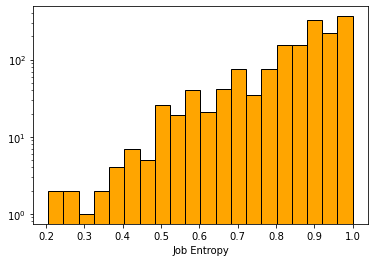

In [52]:
conditional_probs = {}

# Iterate through course nodes
for course_node in B.nodes(data=True):
    if course_node[1]['bipartite'] == 0:  # Check if it's a course node
        course_name = course_node[0]
        skill_neighbors = list(B.neighbors(course_name))

        if not skill_neighbors:
            continue  # Skip course nodes with no skill neighbors

        # Count the occurrence of each job sector in the neighbors
        job_sector_counts = {}
        for skill_neighbor in skill_neighbors:
            if 'job_sector' in B.nodes[skill_neighbor]:
                job_sector = B.nodes[skill_neighbor]['job_sector']
                job_sector_counts[job_sector] = job_sector_counts.get(job_sector, 0) + 1

        # Calculate conditional probabilities
        conditional_probs[course_name] = {job_sector: count / len(skill_neighbors) for job_sector, count in job_sector_counts.items()}


# Filter out course nodes with empty conditional_probs
conditional_probs = {course_name: probs for course_name, probs in conditional_probs.items() if probs}

# Calculate entropy for each course node using scipy.stats.entropy
job_entropy_values = {}
for course_name, conditional_probabilities in conditional_probs.items():
    prob_values = np.array(list(conditional_probabilities.values()))

    num_groups = len(conditional_probs[course_name])

    if num_groups >= 2:
       entropy_value = entropy(prob_values, base=num_groups)
 #   log_scaled_entropy_value = entropy_value / np.log(num_groups)
    else:
       entropy_value = None  # Assign None for courses with no skill categories

    #if num_groups > 0:
    #    entropy_value = entropy(prob_values)
        #log_scaled_entropy_value = entropy_value / np.log(num_groups) if num_groups > 1 else 0
    #else:
    #    entropy_value = None
    #    #log_scaled_entropy_value = None
    
    job_entropy_values[course_name] = entropy_value #log_scaled_entropy_value

# Create a histogram to visualize the distribution of entropy values
entropy_list = [value for value in job_entropy_values.values() if value is not None]

plt.hist(entropy_list, bins=20, color='orange', edgecolor='black')
plt.xlabel('Job Entropy')
plt.yscale('log')
plt.savefig('job_entropy.png', bbox_inches='tight')
plt.show()

In [53]:
# Assign values from skills_data to partition 1 nodes
skill_data = df_skill.set_index('id')['skill_label'].to_dict()

for skill_name in skill_names:
    if skill_name in skill_data:
        value =  skill_data[skill_name]
        B.nodes[skill_name]['skill_category'] = value  # Add 'value' attribute to the node

In [54]:
# Calculate the overall unique job sectors
unique_skill_categories = set()
for skill_node in B.nodes(data=True):
    if skill_node[1]['bipartite'] == 1 and 'skill_category' in skill_node[1]:
        unique_skill_categories.add(skill_node[1]['skill_category'])

overall_num_unique_skill_categories = len(unique_skill_categories)
print(overall_num_unique_skill_categories)

321


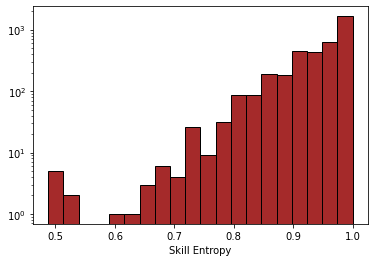

In [55]:
# Create a dictionary to store conditional probabilities of job sectors given skill neighbors
conditional_probs = {}

# Iterate through course nodes
for course_node in B.nodes(data=True):
    if course_node[1]['bipartite'] == 0:  # Check if it's a course node
        course_name = course_node[0]
        skill_neighbors = list(B.neighbors(course_name))

        if not skill_neighbors:
            continue  # Skip course nodes with no skill neighbors

        # Count the occurrence of each job sector in the neighbors
        skill_category_counts = {}
        for skill_neighbor in skill_neighbors:
            if 'skill_category' in B.nodes[skill_neighbor]:
                skill_category = B.nodes[skill_neighbor]['skill_category']
                skill_category_counts[skill_category] = skill_category_counts.get(skill_category, 0) + 1

        # Calculate conditional probabilities
        conditional_probs[course_name] = {skill_category: count / len(skill_neighbors) for skill_category, count in skill_category_counts.items()}

# Calculate entropy for each course node using scipy.stats.entropy
skill_entropy_values = {}
for course_name, conditional_probabilities in conditional_probs.items():
    prob_values = np.array(list(conditional_probabilities.values()))

    num_groups = len(conditional_probs[course_name])

    if num_groups >= 2:
       entropy_value = entropy(prob_values, base=num_groups)
    else:
       entropy_value = None  # Assign None for courses with no skill categories

    skill_entropy_values[course_name] = entropy_value

    # Create a histogram to visualize the distribution of entropy values
entropy_list = [value for value in skill_entropy_values.values() if value is not None]
plt.hist(entropy_list, bins=20, color='brown', edgecolor='black')
plt.xlabel('Skill Entropy')
plt.yscale('log')
plt.savefig('skill_entropy.png', bbox_inches='tight')
plt.show()

In [ ]:
##Course Impact 계산 및 회귀

In [56]:
# Assuming G is your network and entropy_values is the dictionary of entropy values

for node in G.nodes(data=True):
    node_name = node[1]['name']  # Assuming 'name' is the attribute to match
    if node_name in skill_entropy_values:
        entropy_value = skill_entropy_values[node_name]
        G.nodes[node[0]]['skill_entropy_value'] = entropy_value

In [57]:
# Assuming G is your network and entropy_values is the dictionary of entropy values

for node in G.nodes(data=True):
    node_name = node[1]['name']  # Assuming 'name' is the attribute to match
    if node_name in job_entropy_values:
        entropy_value = job_entropy_values[node_name]
        G.nodes[node[0]]['job_entropy_value'] = entropy_value

In [89]:
# Your existing code to create the 'node_data_list'
node_data_list = []
for node in G.nodes():
    node_data = {
        'course_name': G.nodes[node]['name'],
        'coverage': G.nodes[node]['course_coverage'],
        #'green_transferability': G.nodes[node]['green_transferability'],
        #'digital_transferability': G.nodes[node]['digital_transferability'],
        #'care_transferability': G.nodes[node]['care_transferability'],
        #'i40_transferability': G.nodes[node]['i40_transferability'],
        'label':G.nodes[node]['label'],
        'degree': G.degree(node)}  # Add the 'degree' attribute
    node_data_list.append(node_data)

# Create a Pandas DataFrame
linear_df = pd.DataFrame(node_data_list)
linear_df

,course_name,coverage,label,degree
0,Certificate in Athlete Life Coaching,1.0,Sports,28
1,Developing People,23.0,Leadership & People Management,434
2,Coaching for Peak Performance,7.0,Wholesale and Retail Trade,193
3,Coach for Service Performance (Service Coachin...,4.0,Service Excellence,33
4,Career Coaching Level 5: Develop and Implement...,3.0,"Human Resource Management, Employment and Recr...",74
...,...,...,...,...
6183,"Chemistry, Manufacturing and Controls (Synchro...",1.0,Healthcare,1
6184,International and Comparative Insolvency Law i...,1.0,Legal,1
6185,Corporate Insolvency Law,2.0,Business Management,1
6186,Working with Families (In-Service Staff),1.0,Healthcare,1


In [59]:
# Initialize a list to store the entropy values
job_entropy_values_list = []

# Iterate through nodes in G and append the entropy values to the list
for node in G.nodes(data=True):
    if 'job_entropy_value' in node[1]:
        job_entropy_values_list.append(node[1]['job_entropy_value'])
    else:
        job_entropy_values_list.append(None)  # Handle the case where entropy_value is missing

# Add the entropy_values list as a new column to the DataFrame
linear_df['job_entropy_value'] = job_entropy_values_list

In [60]:
# Initialize a list to store the entropy values
skill_entropy_values_list = []

# Iterate through nodes in G and append the entropy values to the list
for node in G.nodes(data=True):
    if 'skill_entropy_value' in node[1]:
        skill_entropy_values_list.append(node[1]['skill_entropy_value'])
    else:
        skill_entropy_values_list.append(None)  # Handle the case where entropy_value is missing

# Add the entropy_values list as a new column to the DataFrame
linear_df['skill_entropy_value'] = skill_entropy_values_list

In [76]:
linear_df.to_csv('linear_df.csv', index=False)

In [61]:
linear_df.isnull().sum()

course_name               0
coverage                  0
label                     0
degree                    0
job_entropy_value      4601
skill_entropy_value    2394
dtype: int64

0.07692307692307693


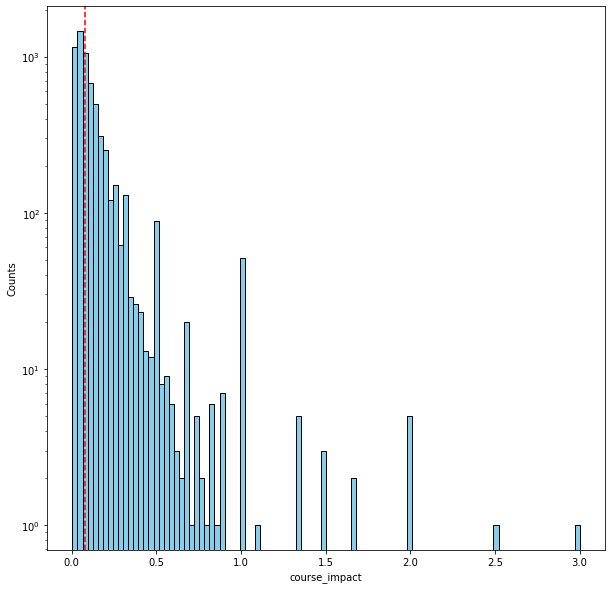

In [90]:
# Calculate 'new_index' for all rows
linear_df['course_impact'] = linear_df['coverage'] / linear_df['degree']

# Create a histogram with a log-scale y-axis
plt.figure(figsize=(10, 10))
n, bins, patches = plt.hist(linear_df['course_impact'], bins=100, edgecolor='k', color='skyblue',density=False)
plt.xlabel('course_impact')
plt.ylabel('Counts')
plt.yscale('log')  # Set the y-axis to a logarithmic scale

# Calculate the median of the 'new_index' column
median_value = linear_df['course_impact'].median()
print(median_value)

# Add a red vertical line at the median value
plt.axvline(median_value, color='red', linestyle='--')
plt.savefig('course_impact_distribution.png')
plt.show()

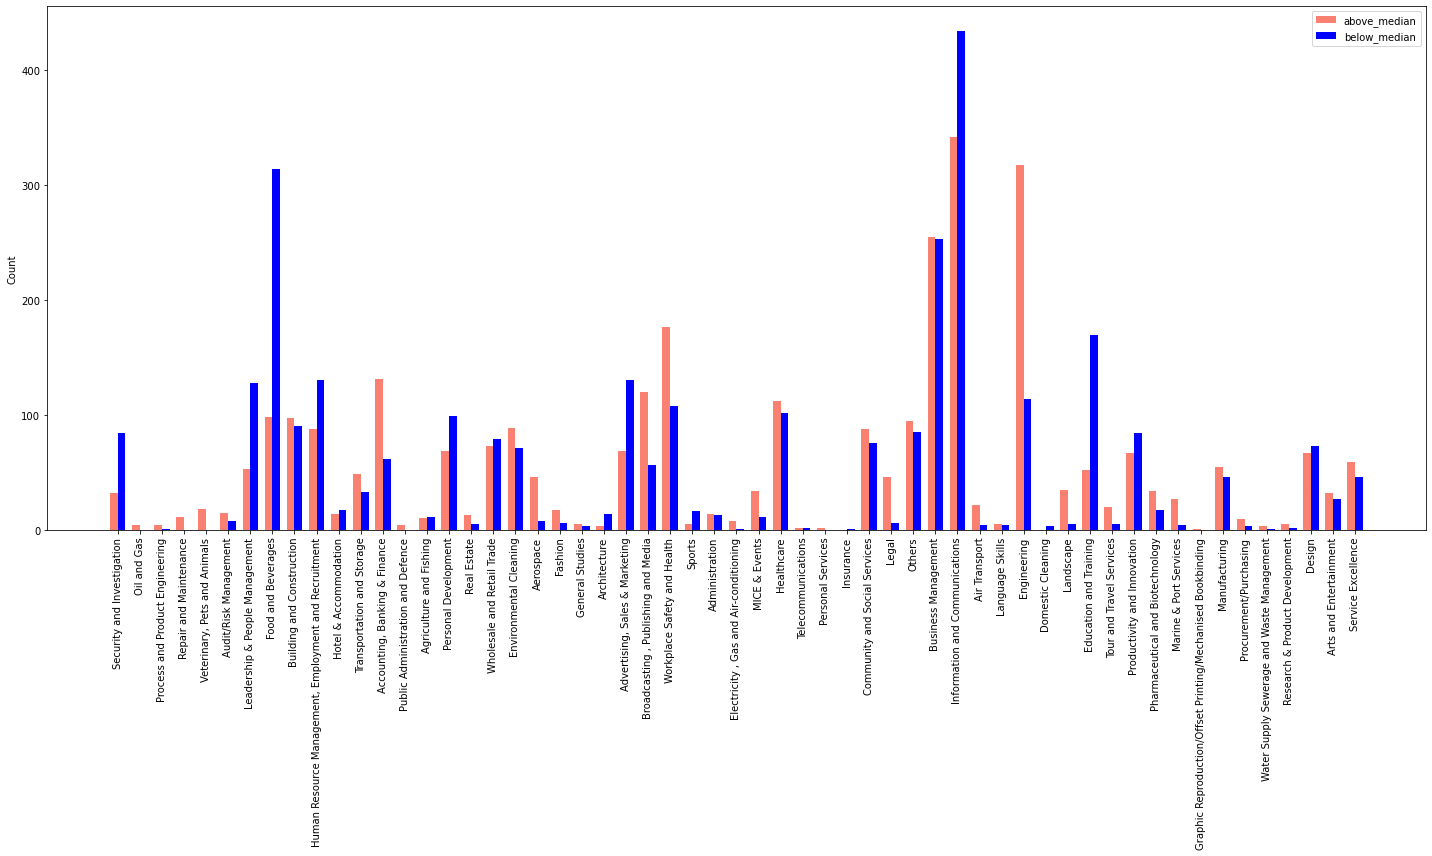

In [74]:
# Extract 'course_name' for rows where 'new_index' is greater than 2.0
above_median_courses = linear_df.loc[linear_df['course_impact'] >= median_value, 'label']
below_median_courses = linear_df.loc[linear_df['course_impact'] < median_value, 'label']

# Count the occurrences of each unique course_name in selected_courses_1 and selected_courses_2
above_median = above_median_courses.value_counts()
below_median = below_median_courses.value_counts()

# Combine the course names from both counts
all_courses = set(above_median.index).union(below_median.index)

# Create a figure
fig, ax = plt.subplots(figsize=(20, 12))

# Calculate the position for each course name
x = np.arange(len(all_courses))

# Bar width
bar_width = 0.35

# Create bars for selected_courses_1
ax.bar(x - bar_width/2, [above_median.get(course, 0) for course in all_courses], bar_width, label='above_median', color='salmon')
ax.bar(x + bar_width/2, [below_median.get(course, 0) for course in all_courses], bar_width, label='below_median', color='blue')

# Set x-axis labels
ax.set_xticks(x)
ax.set_xticklabels(all_courses, rotation=90)
ax.set_ylabel("Count")
ax.legend()

# Adjust layout and display the chart
plt.tight_layout()
plt.show()

In [ ]:
above_median = above_median_courses.value_counts()
below_median = below_median_courses.value_counts()

# Combine the course names from both counts
all_courses = list(set(above_median.index).union(below_median.index))

# Calculate the total count for each course name by combining count_courses_1 and count_courses_2
total_counts = [above_median.get(course, 0) + below_median.get(course, 0) for course in all_courses]

# Calculate the ratios of count_courses_1 and count_courses_2 to total_counts for each course name
ratios_1 = [above_median.get(course, 0) / total_counts[i] for i, course in enumerate(all_courses)]
ratios_2 = [below_median.get(course, 0) / total_counts[i] for i, course in enumerate(all_courses)]

# Sort the bars based on ratios_1 (blue color)
sorted_indices = np.argsort(ratios_1)
all_courses = [all_courses[i] for i in sorted_indices]
ratios_1 = [ratios_1[i] for i in sorted_indices]
ratios_2 = [ratios_2[i] for i in sorted_indices]

# Create a figure
fig, ax = plt.subplots(figsize=(12, 12),dpi=300)

# Calculate the position for each course name
y = np.arange(len(all_courses))

# Bar width for each group of bars
bar_width = 0.35

# Create bars for count_courses_1 ratios
ax.barh(y, ratios_1, bar_width, label='above_median', color='salmon')

# Create bars for count_courses_2 ratios
ax.barh(y, ratios_2, bar_width, label='below_median', color='blue', left=ratios_1)  # Align bars for comparison

# Set y-axis labels
ax.set_yticks(y)
ax.set_yticklabels(all_courses)
ax.set_xlim(0, 1)  # Set the x-axis limit to 0-1 for ratios
ax.set_xlabel("Ratio")
ax.legend()

# Adjust layout and display the chart
plt.tight_layout()
plt.savefig('course_impact_by_sector.png')
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


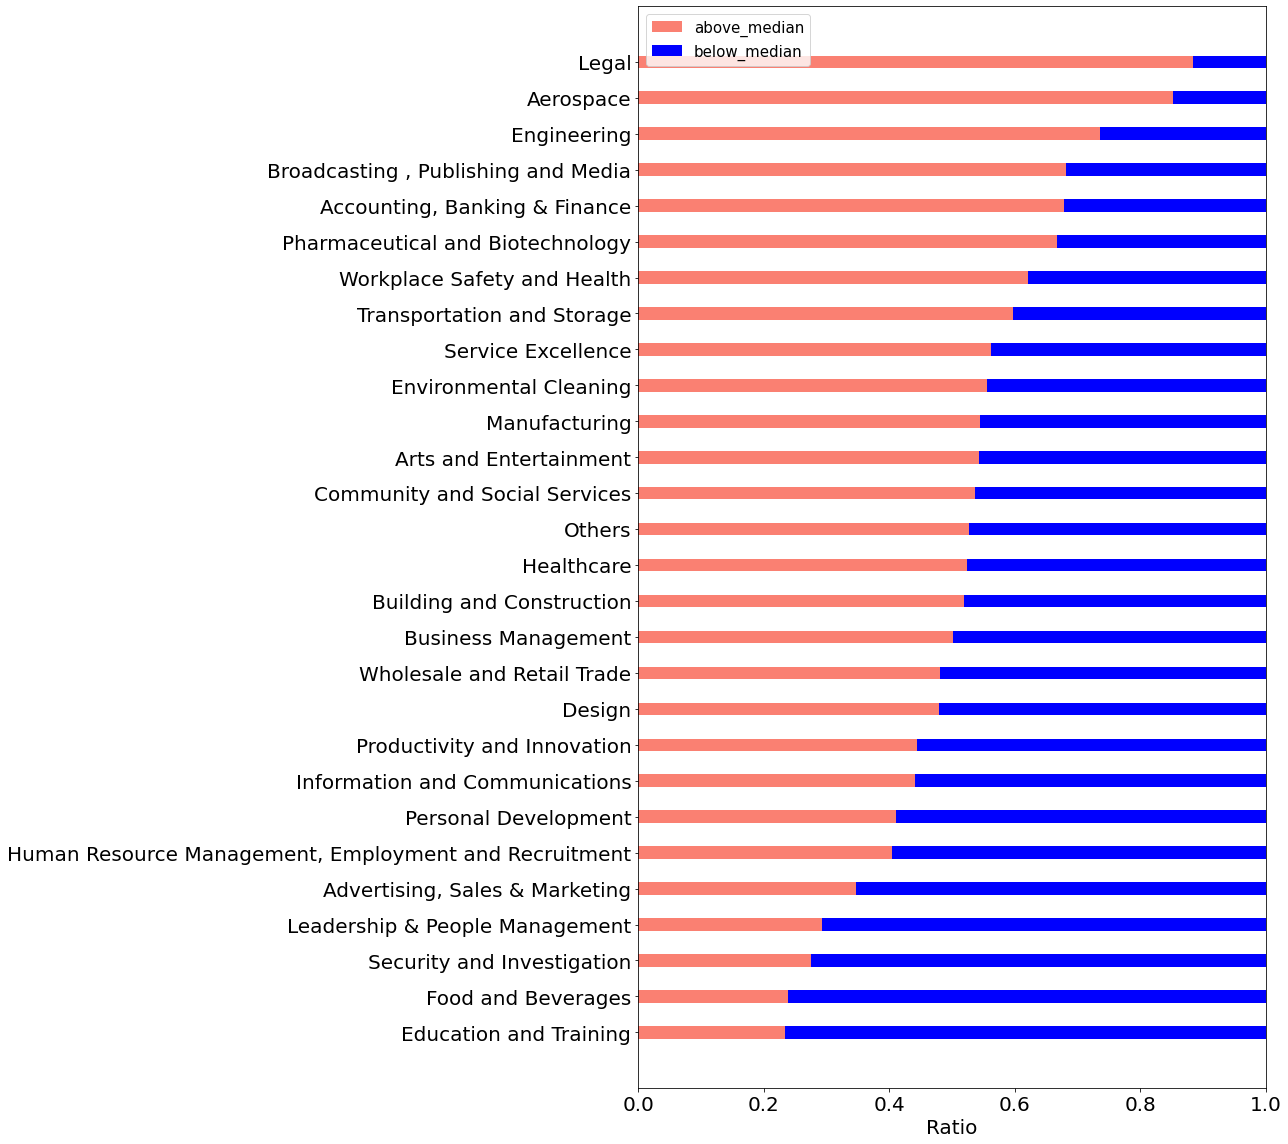

In [78]:
above_median = above_median_courses.value_counts()
below_median = below_median_courses.value_counts()

# Combine the course names from both counts
all_courses = list(set(above_median.index).union(below_median.index))

# Calculate the total count for each course name by combining count_courses_1 and count_courses_2
total_counts = [above_median.get(course, 0) + below_median.get(course, 0) for course in all_courses]

# Filter out courses with total_counts less than 20
filtered_courses = [course for course, count in zip(all_courses, total_counts) if count >= 50]

# Calculate the ratios of count_courses_1 and count_courses_2 to total_counts for each course name
ratios_1 = [above_median.get(course, 0) / total_counts[i] for i, course in enumerate(all_courses)]
ratios_2 = [below_median.get(course, 0) / total_counts[i] for i, course in enumerate(all_courses)]

# Filter ratios based on filtered courses
ratios_1 = [ratio for course, ratio in zip(all_courses, ratios_1) if course in filtered_courses]
ratios_2 = [ratio for course, ratio in zip(all_courses, ratios_2) if course in filtered_courses]

# Sort the bars based on ratios_1 (blue color)
sorted_indices = np.argsort(ratios_1)
filtered_courses = [filtered_courses[i] for i in sorted_indices]
ratios_1 = [ratios_1[i] for i in sorted_indices]
ratios_2 = [ratios_2[i] for i in sorted_indices]

# Create a figure
fig, ax = plt.subplots(figsize=(18, 16))

# Calculate the position for each course name
y = np.arange(len(filtered_courses))

# Bar width for each group of bars
bar_width = 0.35

# Create bars for count_courses_1 ratios
ax.barh(y, ratios_1, bar_width, label='above_median', color='salmon')

# Create bars for count_courses_2 ratios
ax.barh(y, ratios_2, bar_width, label='below_median', color='blue', left=ratios_1)  # Align bars for comparison

# Set y-axis labels
ax.set_yticks(y)
ax.set_yticklabels(filtered_courses, fontsize=20)
ax.set_xlim(0, 1)  # Set the x-axis limit to 0-1 for ratios
ax.tick_params(axis='x', labelsize=20)
ax.set_xlabel("Ratio",fontsize=20)
ax.legend(fontsize=15)

# Adjust layout and display the chart
plt.tight_layout()
plt.savefig('course_impact_by_sector.png',dpi=300)

plt.show()

In [63]:
linear_df.dropna(subset=['job_entropy_value', 'skill_entropy_value'], inplace=True)
linear_df

,course_name,coverage,label,degree,job_entropy_value,skill_entropy_value,course_impact
9,Facilitating Career Development (Synchronous &...,14.0,Business Management,388,0.650022,0.967132,0.036082
33,Manage Engineering Project [CAM & CNC Machinin...,9.0,Design,101,1.000000,0.975504,0.089109
58,AutoCAD for Design and Drafting Professional,9.0,Information and Communications,107,0.918296,0.969724,0.084112
76,Certificate in Engineering Drafting & Design (...,6.0,Manufacturing,88,1.000000,1.000000,0.068182
81,CAD and Engineering Design,10.0,Engineering,105,0.918296,0.916516,0.095238
...,...,...,...,...,...,...,...
5509,WSQ Diploma in Media (Post-Production) - Sound...,10.0,"Broadcasting , Publishing and Media",16,0.954434,1.000000,0.625000
5525,Lighting for Environment (Modular Unit to stac...,7.0,Design,19,0.811278,1.000000,0.368421
5528,Human centric lightings design in built enviro...,7.0,Engineering,19,0.811278,1.000000,0.368421
5529,MEC6018 Lighting Technology for Building Services,7.0,Engineering,19,0.811278,1.000000,0.368421


In [66]:
temp = pd.merge(linear_df, kc_df, left_on='course_name', right_on='Node',how='left')
temp

,course_name,coverage,label,degree,job_entropy_value,skill_entropy_value,course_impact,Node,kc0,kc1,kc2
0,Facilitating Career Development (Synchronous &...,14.0,Business Management,388,0.650022,0.967132,0.036082,Facilitating Career Development (Synchronous &...,14.0,64.642857,21.454122
1,Manage Engineering Project [CAM & CNC Machinin...,9.0,Design,101,1.000000,0.975504,0.089109,Manage Engineering Project [CAM & CNC Machinin...,9.0,31.000000,9.879316
2,AutoCAD for Design and Drafting Professional,9.0,Information and Communications,107,0.918296,0.969724,0.084112,AutoCAD for Design and Drafting Professional,9.0,24.555556,9.251975
3,Certificate in Engineering Drafting & Design (...,6.0,Manufacturing,88,1.000000,1.000000,0.068182,Certificate in Engineering Drafting & Design (...,6.0,29.666667,13.131115
4,CAD and Engineering Design,10.0,Engineering,105,0.918296,0.916516,0.095238,CAD and Engineering Design,10.0,26.200000,9.683996
...,...,...,...,...,...,...,...,...,...,...,...
1397,WSQ Diploma in Media (Post-Production) - Sound...,10.0,"Broadcasting , Publishing and Media",16,0.954434,1.000000,0.625000,WSQ Diploma in Media (Post-Production) - Sound...,10.0,9.800000,9.247803
1398,Lighting for Environment (Modular Unit to stac...,7.0,Design,19,0.811278,1.000000,0.368421,Lighting for Environment (Modular Unit to stac...,7.0,12.428571,5.966106
1399,Human centric lightings design in built enviro...,7.0,Engineering,19,0.811278,1.000000,0.368421,Human centric lightings design in built enviro...,7.0,12.428571,5.966106
1400,MEC6018 Lighting Technology for Building Services,7.0,Engineering,19,0.811278,1.000000,0.368421,MEC6018 Lighting Technology for Building Services,7.0,12.428571,5.966106


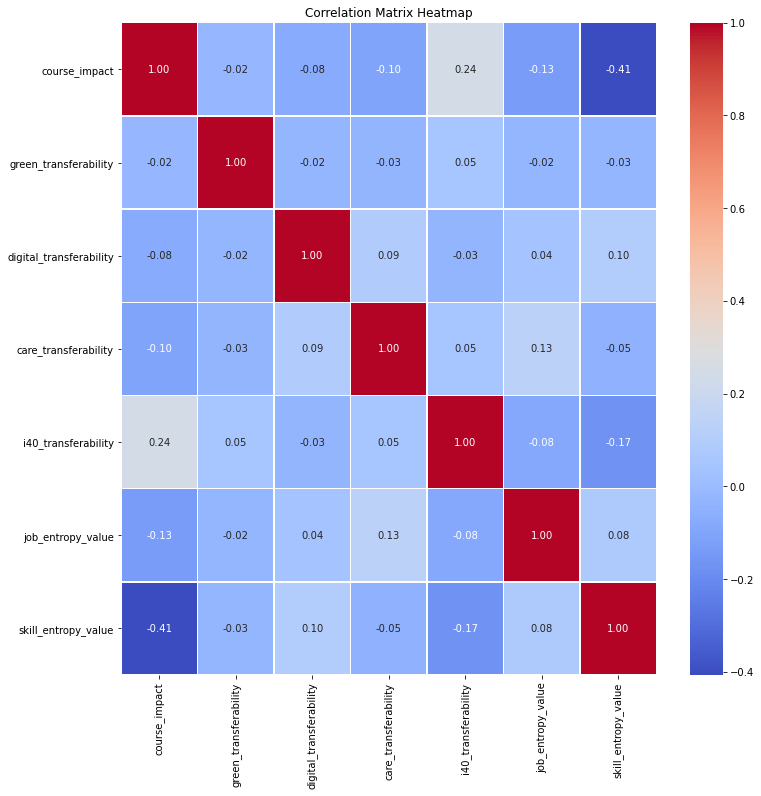

In [242]:
correlation_matrix = linear_df[['course_impact','green_transferability','digital_transferability','care_transferability','i40_transferability','job_entropy_value', 'skill_entropy_value']].corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 12))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add labels and title
plt.title('Correlation Matrix Heatmap')
plt.show()

In [243]:
# Initialize the Min-Max scaler
scaler = MinMaxScaler()

# Define the columns you want to normalize (in this case, 'transferability' columns)
columns_to_normalize = ['green_transferability', 'digital_transferability', 'care_transferability', 'i40_transferability']

linear_df[columns_to_normalize] = scaler.fit_transform(linear_df[columns_to_normalize])

In [75]:
import statsmodels.api as sm

# Fit the linear regression model with dummy variables for 'label'
reg = sm.OLS.from_formula('course_impact ~ job_entropy_value + skill_entropy_value + C(label) +1', linear_df).fit()

# Print the summary
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:          course_impact   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     12.71
Date:                Thu, 14 Dec 2023   Prob (F-statistic):           1.44e-77
Time:                        22:49:46   Log-Likelihood:                 1668.0
No. Observations:                1402   AIC:                            -3240.
Df Residuals:                    1354   BIC:                            -2988.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [139]:
# Iterate through course nodes
#for course_node in B.nodes(data=True):
#    if course_node[1]['bipartite'] == 0:  # Check if it's a course node
#        course_name = course_node[0]
#        skill_neighbors = list(B.neighbors(course_name))
#
#        if not skill_neighbors:
#            continue  # Skip course nodes with no skill neighbors

        # Count the occurrence of each job sector in the neighbors
#        job_sector_counts = {}
#        for skill_neighbor in skill_neighbors:
#            if 'job_sector' in B.nodes[skill_neighbor]:
#                job_sector = B.nodes[skill_neighbor]['job_sector']
#                job_sector_counts[job_sector] = job_sector_counts.get(job_sector, 0) + 1

In [ ]:
# Assign values from skills_data to partition 1 nodes
course_data = filtered_course_df.set_index('title')['label'].to_dict()

for course_name in course_names:
    if course_name in course_data:
        value =  course_data[course_name]
        B.nodes[course_name]['course_label'] = value  # Add 'value' attribute to the node

# Iterate through skill nodes
for skill_node in B.nodes(data=True):
    if skill_node[1]['bipartite'] == 1 and 'job_sector' in skill_node[1]:  # Check if it's a skill node with 'job_sector'
        skill_name = skill_node[0]
        course_neighbors = list(B.neighbors(skill_name))

        # Print the number of course node neighbors for each skill node with 'job_sector'
        print(f"Skill: {skill_name}, Number of Course Node Neighbors: {len(course_neighbors)}")

In [77]:
job_data = df_job.set_index('id')['sector_label'].to_dict()

for skill_name in skill_names:
    if skill_name in job_data:
        value = job_data[skill_name]
        B.nodes[skill_name]['sector_label'] = value  # Use 'industry' consistently

# Iterate through skill nodes
total_neighbors = 0
total_nodes = 0
job_counts = {}

for skill_node in B.nodes(data=True):
    if skill_node[1]['bipartite'] == 1 and 'sector_label' in skill_node[1]:
        skill_name = skill_node[0]
        course_neighbors = list(B.neighbors(skill_name))

        job = skill_node[1]['sector_label']

        if job not in job_counts:
            job_counts[job] = []
        job_counts[job].append(len(course_neighbors))

        total_neighbors += len(course_neighbors)
        total_nodes += 1

# Calculate average number of neighbors
average_neighbors = total_neighbors / total_nodes if total_nodes > 0 else 0

print("Average number of neighbors for skill nodes with 'job_label':", average_neighbors)

Average number of neighbors for skill nodes with 'job_label': 16.290521978021978


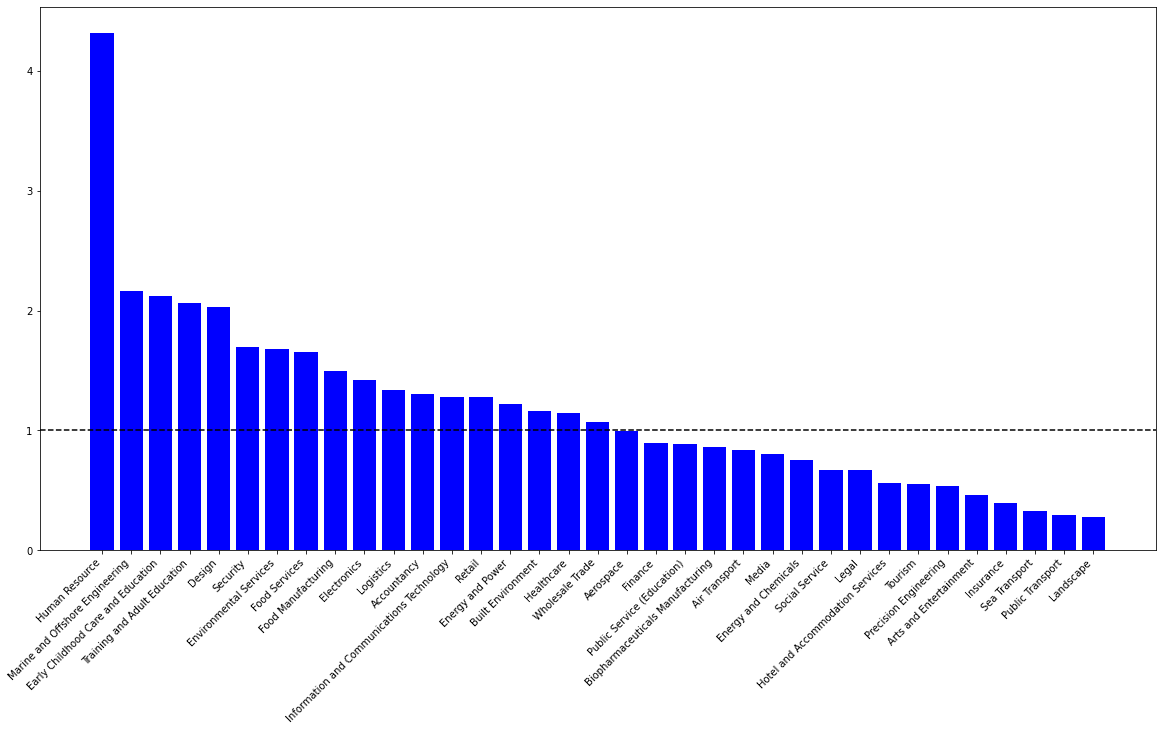

In [78]:
# Dictionary to store the counts of course node neighbors for each industry
course_counts = {}

# Iterate through skill nodes
for skill_node in B.nodes(data=True):
    if skill_node[1]['bipartite'] == 1 and 'sector_label' in skill_node[1]:
        skill_name = skill_node[0]
        course_neighbors = list(B.neighbors(skill_name))

        course = skill_node[1]['sector_label']  # Use 'industry' consistently

        if course not in course_counts:
            course_counts[course] = []
        course_counts[course].append(len(course_neighbors))
        
# Create a DataFrame from the results
data = {'sector_label': [], 'avg_course_relevant': []}
for job_label, counts in course_counts.items():

    job_counts = len(counts)
    average_course_provided = sum(counts) / job_counts

    data['sector_label'].append(job_label)
    data['avg_course_relevant'].append(average_course_provided)

result_df = pd.DataFrame(data)
result_df['inequality_index'] = result_df['avg_course_relevant'] / average_neighbors
# Sort the DataFrame by avg_course_relevant in descending order
result_df = result_df.sort_values(by='inequality_index', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(20, 10))
plt.bar(result_df['sector_label'], result_df['inequality_index'],color='blue')
plt.xticks(rotation=45, ha='right')
# Use plt.bar instead of plt.barh
# Show every 5th job_label on the x-axis
plt.axhline(y=1, color='black', linestyle='--')
plt.savefig('job_course_inequality.png', bbox_inches='tight')
plt.show()

In [79]:
df_skill_tmp = df_skill.copy()
df_skill_tmp['Proficiency Level'] = df_skill_tmp['Proficiency Level'].astype(str)
df_skill_tmp['Proficiency Level'] = df_skill_tmp['Proficiency Level'].replace({'1': 'low', '2': 'low', '3': 'low', '4': 'high', '5': 'high', '6': 'high','Advanced':'high'})
df_skill_tmp['Proficiency Level'].value_counts()

low     2158
high     422
Name: Proficiency Level, dtype: int64

In [80]:
df_skill_tmp

,TSC_CCS Title,TSC_CCS Description,Proficiency Level,Proficiency Description,skill_label,id,text,combined_text,tokenized_sentences
0,Audit Frameworks,Develop quality assurance frameworks to meet r...,high,Analyse the format and content of audit report,Assurance,ACC-AUD-4003-1.1,Analyse the format and content of audit report...,Develop quality assurance frameworks to meet r...,[Develop quality assurance frameworks to meet ...
1,Auditing and Assurance Standards,Use applicable auditing and assurance standard...,high,Perform engagement procedures in accordance wi...,Assurance,ACC-AUD-4001-1.1,Perform engagement procedures in accordance wi...,Use applicable auditing and assurance standard...,[Use applicable auditing and assurance standar...
2,Auditor Independence,Possess the state of mind and appearance where...,low,Communicate importance of auditor's independen...,Assurance,ACC-PVE-3001-1.1,Communicate importance of auditor's independen...,Possess the state of mind and appearance where...,[Possess the state of mind and appearance wher...
3,Engagement Completion and Reporting,Perform procedures involved prior to expressin...,high,Perform engagement completion procedures,Assurance,ACC-AUD-4004-1.1,Perform engagement completion procedures. Eval...,Perform procedures involved prior to expressin...,[Perform procedures involved prior to expressi...
4,Engagement Execution,Perform assurance procedures in accordance wit...,high,Perform assurance procedures,Assurance,ACC-AUD-4005-1.1,Perform assurance procedures. Perform assuranc...,Perform assurance procedures in accordance wit...,[Perform assurance procedures in accordance wi...
...,...,...,...,...,...,...,...,...,...
2575,Workplace Safety and Health Management in Manu...,Manage the operational issues associated with ...,low,Identify common safety and health hazards and ...,Workplace Safety and Health Management,WPH-WSH-2081-1.1,Identify common safety and health hazards and ...,Manage the operational issues associated with ...,[Manage the operational issues associated with...
2576,Workplace Safety and Health Management in Mari...,Manage the operational issues associated with ...,low,Identify common safety and health hazards and ...,Workplace Safety and Health Management,WPH-WSH-2082-1.1,Identify common safety and health hazards and ...,Manage the operational issues associated with ...,[Manage the operational issues associated with...
2577,Workplace Safety and Health Management in Serv...,Manage the operational issues associated with ...,low,Identify common safety and health hazards and ...,Workplace Safety and Health Management,WPH-WSH-2083-1.1,Identify common safety and health hazards and ...,Manage the operational issues associated with ...,[Manage the operational issues associated with...
2578,Workplace Safety and Health Policy Development,Develop organisational workplace safety and he...,low,Monitor legal compliance and report incidents ...,Workplace Safety and Health Management,WPH-WSH-1084-1.1,Monitor legal compliance and report incidents ...,Develop organisational workplace safety and he...,[Develop organisational workplace safety and h...


In [81]:
# Assign values from industry_data to partition 1 nodes
proficiency_info = df_skill_tmp.set_index('id')['Proficiency Level'].to_dict()

for skill_name in skill_names:
    if skill_name in proficiency_info:
        value = proficiency_info[skill_name]
        B.nodes[skill_name]['tsc_proficiency'] = value  # Use 'industry' consistently

In [ ]:
# Iterate through course nodes
for course_node in B.nodes(data=True):
    if course_node[1]['bipartite'] == 0:  # Check if it's a course node
        course_name = course_node[0]
        skill_neighbors = list(B.neighbors(course_name))

        if not skill_neighbors:
            continue  # Skip course nodes with no skill neighbors

        print(f"Course: {course_name}")
        for skill_neighbor in skill_neighbors:
            if 'tsc_proficiency' in B.nodes[skill_neighbor]:
                tsc_proficiency_category = B.nodes[skill_neighbor]['tsc_proficiency']
                print(f" - Skill: {skill_neighbor}, Skill Category: {tsc_proficiency_category}")

In [83]:
# Initialize dictionaries to store counts
count_low = {}
count_high = {}

# Iterate through course nodes
for course_node in B.nodes(data=True):
    if course_node[1]['bipartite'] == 0:  # Check if it's a course node
        course_name = course_node[0]
        skill_neighbors = list(B.neighbors(course_name))

        if not skill_neighbors:
            continue  # Skip course nodes with no skill neighbors

        # Initialize counts for the current course
        count_low[course_name] = 0
        count_high[course_name] = 0

        for skill_neighbor in skill_neighbors:
            if 'tsc_proficiency' in B.nodes[skill_neighbor]:
                tsc_proficiency_category = B.nodes[skill_neighbor].get('tsc_proficiency')

                # Update counts based on proficiency category
                if tsc_proficiency_category == 'low':
                    count_low[course_name] += 1
                elif tsc_proficiency_category == 'high':
                    count_high[course_name] += 1

# Check if both dictionaries are not empty before creating the DataFrame
if count_low and count_high:
    # Create a DataFrame from the counts
    df_counts = pd.DataFrame({
        'course_name': list(count_low.keys()),
        'Low_Count': list(count_low.values()),
        'High_Count': list(count_high.values())
    })

    # Add 'course_label' attribute to the DataFrame
    df_counts['course_label'] = df_counts['course_name'].apply(lambda x: B.nodes[x]['course_label'])

    # Optionally, you can set the 'course_name' column as the index
    df_counts.set_index('course_name', inplace=True)
else:
    print("No data to create DataFrame.")

In [84]:
# Group by 'course_label' and sum the counts for each group
df_grouped = df_counts.groupby('course_label').agg({'Low_Count': 'sum', 'High_Count': 'sum'}).reset_index()

# Add 'Proficiency_score' column
total_high_counts = 422
total_low_counts = 2158 
df_grouped['Proficiency_score'] = df_grouped['High_Count'] / (df_grouped['High_Count'] + df_grouped['Low_Count'])
df_grouped['Proficiency_score'] = df_grouped['Proficiency_score'] / (total_high_counts / (total_high_counts + total_low_counts))
df_grouped = df_grouped.drop(columns=['Low_Count','High_Count'])
df_grouped

,course_label,Proficiency_score
0,"Accounting, Banking & Finance",1.045993
1,Administration,0.846518
2,"Advertising, Sales & Marketing",0.705082
3,Aerospace,0.576768
4,Agriculture and Fishing,0.265815
5,Air Transport,0.569417
6,Architecture,0.000000
7,Arts and Entertainment,0.000000
8,Audit/Risk Management,1.191988
9,"Broadcasting , Publishing and Media",0.717944


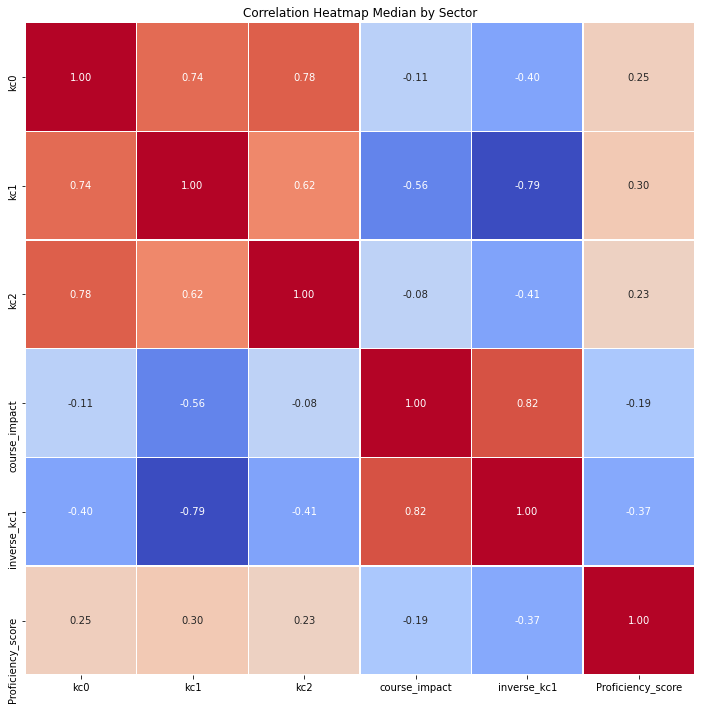

In [95]:
merged_df_total = pd.merge(median_kc_filtered, df_grouped, left_on='label',right_on='course_label', how='left')
merged_df_total = merged_df_total.drop(columns=['course_label'])
merged_df_total

correlation_matrix = merged_df_total.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 12))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=False)

# Add labels and title
plt.title('Correlation Heatmap Median by Sector')

plt.savefig('kcvalues_sector_median.png', bbox_inches='tight')
plt.show()

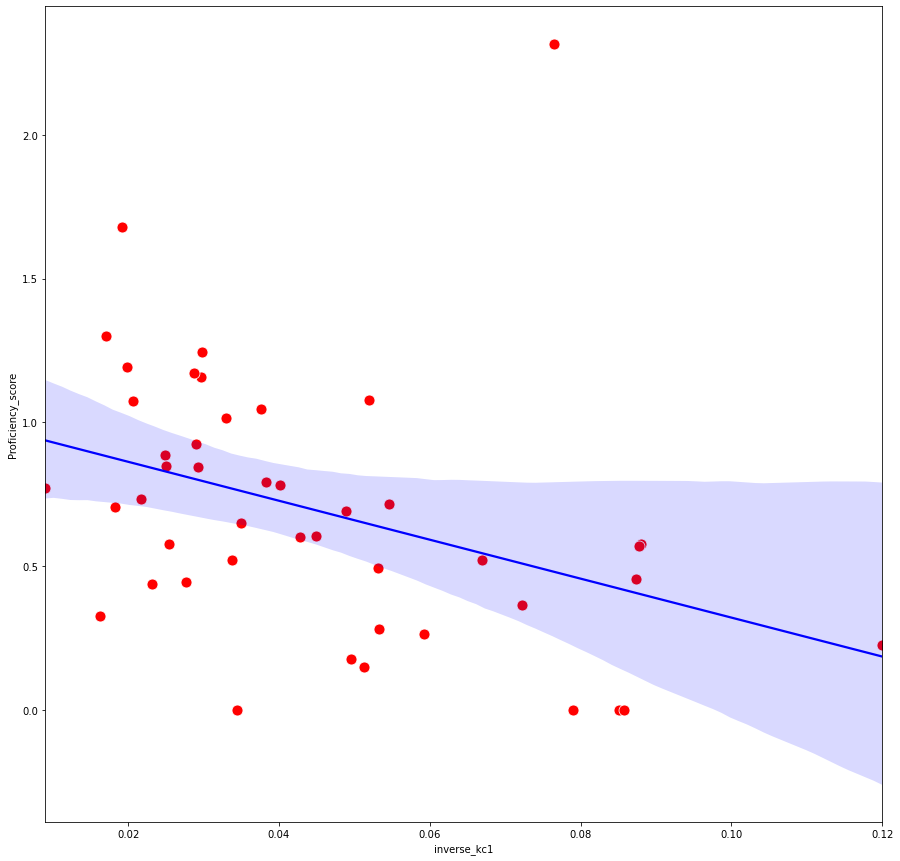

In [97]:
# Create a scatter plot
plt.figure(figsize=(15, 15))
sns.scatterplot(x='inverse_kc1', y='Proficiency_score', data=merged_df_total, color='red', s=120)

# Draw a fitted line (regression line)
sns.regplot(x='inverse_kc1', y='Proficiency_score', data=merged_df_total, scatter=False, color='blue')
plt.show()